### loading necessary imports

In [1]:
# =====================================================================
#  CORE LIBRARIES
# =====================================================================
import os
import gc
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

warnings.filterwarnings('ignore')

# =====================================================================
#  VISUALIZATION
# =====================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, brier_score_loss,
    roc_curve, precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

# =====================================================================
# 🧠 MODELING & OPTIMIZATION
# =====================================================================
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

# Gradient boosting frameworks
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

### loading the data

In [2]:
# ==================== MAIN EXECUTION ====================

# Find project root
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

# Paths
PROCESSED_DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.parquet'
ARTIFACTS_PATH = PROJECT_ROOT / 'artifacts' / 'split data sets'

print("="*60)
print("DATA SPLIT & SAVE")
print("="*60)
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ processed data: {PROCESSED_DATA_PATH}")
print(f"✓ Artifacts: {ARTIFACTS_PATH}")
print("="*60)

# Check file exists
if not PROCESSED_DATA_PATH.exists():
    print(f"\n❌ ERROR: processed data not found at: {PROCESSED_DATA_PATH}")
    exit(1)

# Load processed data
print("\n📂 Loading processed data...")
df = pd.read_parquet(PROCESSED_DATA_PATH)
print(f"✓ Loaded: {df.shape}")

# Target label mapping
target_labels = {0: 'No Disease', 1: 'Disease'}

print(f"\n📊 Target Distribution:")
target_dist = df['target'].map(target_labels).value_counts()
for label, count in target_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

# Split
print(f"\n📊 Splitting data (70/30)...")
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✓ Train: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"✓ Test:  {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

# Create directory if not exists
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

# Save (always overwrite)
print(f"\n💾 Saving splits...")
X_train.to_parquet(ARTIFACTS_PATH / 'X_train.parquet', index=False)
X_test.to_parquet(ARTIFACTS_PATH / 'X_test.parquet', index=False)
y_train.to_frame().to_parquet(ARTIFACTS_PATH / 'y_train.parquet', index=False)
y_test.to_frame().to_parquet(ARTIFACTS_PATH / 'y_test.parquet', index=False)

# Summary
print("\n" + "="*60)
print("✓ SPLIT & SAVE COMPLETE")
print("="*60)
print(f"Shape: Train {X_train.shape} | Test {X_test.shape}")

# Train target
print(f"\nTrain Target Distribution:")
train_target_dist = y_train.map(target_labels).value_counts()
for label, count in train_target_dist.items():
    pct = (count / len(y_train)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

# Test target
print(f"\nTest Target Distribution:")
test_target_dist = y_test.map(target_labels).value_counts()
for label, count in test_target_dist.items():
    pct = (count / len(y_test)) * 100
    print(f"  {label:12s}: {count:>6,} ({pct:>5.2f}%)")

print(f"\nSaved to: {ARTIFACTS_PATH}")
print(f"  - X_train.parquet")
print(f"  - X_test.parquet")
print(f"  - y_train.parquet")
print(f"  - y_test.parquet")
print("="*60)

DATA SPLIT & SAVE
✓ Project root: p:\projects\heart_disease_prediction
✓ processed data: p:\projects\heart_disease_prediction\data\processed\processed_data.parquet
✓ Artifacts: p:\projects\heart_disease_prediction\artifacts\split data sets

📂 Loading processed data...
✓ Loaded: (69976, 14)

📊 Target Distribution:
  No Disease  : 35,004 (50.02%)
  Disease     : 34,972 (49.98%)

📊 Splitting data (70/30)...
✓ Train: 48,983 (70.0%)
✓ Test:  20,993 (30.0%)

💾 Saving splits...

✓ SPLIT & SAVE COMPLETE
Shape: Train (48983, 13) | Test (20993, 13)

Train Target Distribution:
  No Disease  : 24,503 (50.02%)
  Disease     : 24,480 (49.98%)

Test Target Distribution:
  No Disease  : 10,501 (50.02%)
  Disease     : 10,492 (49.98%)

Saved to: p:\projects\heart_disease_prediction\artifacts\split data sets
  - X_train.parquet
  - X_test.parquet
  - y_train.parquet
  - y_test.parquet


### Base model selection

In [3]:
# ============================================================================
# LOAD DATA
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'

# Load 70% train and 30% test
X_train = pd.read_parquet(ARTIFACTS_DIR / 'X_train.parquet')
X_test_full = pd.read_parquet(ARTIFACTS_DIR / 'X_test.parquet')
y_train = pd.read_parquet(ARTIFACTS_DIR / 'y_train.parquet').iloc[:, 0]
y_test_full = pd.read_parquet(ARTIFACTS_DIR / 'y_test.parquet').iloc[:, 0]

print(f"✓ Data loaded: Train {X_train.shape}, Test {X_test_full.shape}")

# Split test data into validation (10%), calibration (10%), and test (10%)
X_temp, X_val, y_temp, y_val = train_test_split(
    X_test_full, y_test_full, test_size=1/3, stratify=y_test_full, random_state=42
)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"  → Validation:  {X_val.shape} (10%)")
print(f"  → Calibration: {X_cal.shape} (10%)")
print(f"  → Test:        {X_test.shape} (10%)\n")

# ============================================================================
# MODELS
# ============================================================================
models = {
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        tree_method='gpu_hist', gpu_id=0,
        random_state=42, verbosity=0
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        num_leaves=15, subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbose=-1, n_jobs=-1
    ),
    
    'CatBoost': CatBoostClassifier(
        iterations=200, depth=4, learning_rate=0.05,
        l2_leaf_reg=3, random_strength=1,
        bagging_temperature=1, border_count=128,
        random_seed=42, verbose=False
    ),
    
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=6, min_samples_split=20,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200, max_depth=8, min_samples_split=15,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, max_features='sqrt', random_state=42
    ),
    
    'LogisticRegression': LogisticRegression(
        C=1.0, penalty='l2', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    
    'GaussianNB': GaussianNB()
}

# ============================================================================
# EVALUATE
# ============================================================================
def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    
    train_auc = roc_auc_score(y_train, y_train_proba)
    val_auc = roc_auc_score(y_val, y_val_proba)
    
    return {
        'Model': '',
        'Val_AUC': val_auc,
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, zero_division=0),
        'Recall': recall_score(y_val, y_val_pred, zero_division=0),
        'F1': f1_score(y_val, y_val_pred, zero_division=0),
        'Train_AUC': train_auc,
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Overfitting_Gap': train_auc - val_auc
    }

# ============================================================================
# RUN EVALUATION
# ============================================================================
print("Evaluating models...\n")

results = []
for name, model in models.items():
    try:
        metrics = evaluate_model(model, X_train, X_val, y_train, y_val)
        metrics['Model'] = name
        results.append(metrics)
        print(f"✓ {name}")
    except Exception as e:
        print(f"✗ {name}: {str(e)[:50]}")

# ============================================================================
# RESULTS
# ============================================================================
df_baseline_metrics = pd.DataFrame(results)
df_baseline_metrics = df_baseline_metrics.sort_values('Val_AUC', ascending=False).reset_index(drop=True)
print(df_baseline_metrics.to_string(index=False))

✓ Data loaded: Train (48983, 13), Test (20993, 13)
  → Validation:  (6998, 13) (10%)
  → Calibration: (6997, 13) (10%)
  → Test:        (6998, 13) (10%)

Evaluating models...

✓ XGBoost
✓ LightGBM
✓ CatBoost
✓ RandomForest
✓ ExtraTrees
✓ GradientBoosting
✓ LogisticRegression
✓ GaussianNB
             Model  Val_AUC  Accuracy  Precision   Recall       F1  Train_AUC  CV_AUC_Mean  CV_AUC_Std  Overfitting_Gap
  GradientBoosting 0.801301  0.732066   0.751084 0.693737 0.721272   0.810909     0.801915    0.004719         0.009607
          CatBoost 0.801233  0.732638   0.753271 0.691450 0.721038   0.804276     0.801161    0.004780         0.003043
           XGBoost 0.801190  0.734638   0.755452 0.693452 0.723125   0.811516     0.801722    0.004727         0.010326
          LightGBM 0.800560  0.733638   0.753808 0.693452 0.722371   0.810814     0.801605    0.004605         0.010254
        ExtraTrees 0.798797  0.735210   0.766883 0.675436 0.718261   0.804099     0.798370    0.004703         

### Model Selection and Calibration

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix, 
                              brier_score_loss, recall_score, precision_score)
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

# ============================================================================
# CONFIGURATION
# ============================================================================
RANDOM_STATE = 42
TRIALS = 100
N_ESTIMATORS = 3000
CAT_ITERATIONS = 400
MAX_FNR_CONSTRAINT = 0.20  # ✅ CORRECTED: FNR ≤ 0.20 (Sensitivity ≥ 0.80)

np.random.seed(RANDOM_STATE)

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================
def find_best_threshold(y_true, y_proba):
    """Find threshold that maximizes F1 score"""
    best_f1, best_metrics = 0, {}
    for threshold in np.arange(0.05, 0.95, 0.005):
        y_pred = (y_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_metrics = {
                'threshold': float(threshold), 
                'f1': float(f1), 
                'recall': float(tp / (tp + fn)),
                'sensitivity': float(tp / (tp + fn)),
                'precision': float(tp / (tp + fp)), 
                'fpr': float(fp / (fp + tn)),
                'fnr': float(fn / (fn + tp)),
                'specificity': float(tn / (tn + fp))
            }
    return best_metrics


def optimize_hyperparameters(model_type, X_tr, y_tr, X_val, y_val):
    """Hyperparameter optimization using Optuna"""
    pbar = tqdm(total=TRIALS, desc=f"  {model_type.upper()}", 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
    
    def objective(trial):
        if model_type == 'xgb':
            model = XGBClassifier(
                n_estimators=N_ESTIMATORS,
                max_depth=trial.suggest_int('max_depth', 5, 8),
                learning_rate=trial.suggest_float('learning_rate', 0.02, 0.1, log=True),
                min_child_weight=trial.suggest_int('min_child_weight', 5, 15),
                gamma=trial.suggest_float('gamma', 0.2, 2.0),
                subsample=trial.suggest_float('subsample', 0.65, 0.95),
                colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),
                reg_alpha=trial.suggest_float('reg_alpha', 1.0, 6.0),
                reg_lambda=trial.suggest_float('reg_lambda', 1.0, 6.0),
                tree_method='gpu_hist', gpu_id=0, random_state=RANDOM_STATE, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                     early_stopping_rounds=75, verbose=False)
            
        elif model_type == 'lgbm':
            model = LGBMClassifier(
                n_estimators=N_ESTIMATORS,
                max_depth=trial.suggest_int('max_depth', 5, 8),
                num_leaves=trial.suggest_int('num_leaves', 31, 70),
                learning_rate=trial.suggest_float('learning_rate', 0.02, 0.1, log=True),
                min_child_samples=trial.suggest_int('min_child_samples', 10, 35),
                subsample=trial.suggest_float('subsample', 0.65, 0.95),
                colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),
                reg_alpha=trial.suggest_float('reg_alpha', 1.0, 6.0),
                reg_lambda=trial.suggest_float('reg_lambda', 1.0, 6.0),
                random_state=RANDOM_STATE, verbosity=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                     callbacks=[lgb.early_stopping(75, verbose=False)])
            
        else:  # catboost
            model = CatBoostClassifier(
                iterations=CAT_ITERATIONS,
                learning_rate=trial.suggest_float('learning_rate', 0.04, 0.13, log=True),
                depth=trial.suggest_int('depth', 6, 8),
                l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 2.0, 8.0),
                random_strength=trial.suggest_float('random_strength', 0.5, 1.5),
                min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 35),
                bootstrap_type='Bayesian',
                bagging_temperature=trial.suggest_float('bagging_temperature', 0.5, 1.2),
                task_type='GPU', random_seed=RANDOM_STATE, verbose=False
            )
            model.fit(Pool(X_tr, y_tr), eval_set=Pool(X_val, y_val), 
                     early_stopping_rounds=60, verbose=False)
        
        metrics = find_best_threshold(y_val, model.predict_proba(X_val)[:, 1])
        pbar.update(1)
        return metrics['f1']
    
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=TRIALS, n_jobs=1, show_progress_bar=False)
    pbar.close()
    print(f"     Best F1: {study.best_value:.4f}")
    return study.best_params


# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n" + "="*80)
print("HEART DISEASE PREDICTION - MODEL TRAINING")
print("="*80)
print("\n[1/6] Loading data...")

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

data_dir = PROJECT_ROOT / 'artifacts' / 'split data sets'
MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

X_train_full = pd.read_parquet(data_dir / 'X_train.parquet')
X_test_full = pd.read_parquet(data_dir / 'X_test.parquet')
y_train_full = pd.read_parquet(data_dir / 'y_train.parquet').iloc[:, 0]
y_test_full = pd.read_parquet(data_dir / 'y_test.parquet').iloc[:, 0]

# Recombine and resplit for proper calibration set
X_all = pd.concat([X_train_full, X_test_full], ignore_index=True)
y_all = pd.concat([y_train_full, y_test_full], ignore_index=True)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.30, stratify=y_all, random_state=RANDOM_STATE
)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"  ✅ Train: {len(X_train):,} (70%), Cal: {len(X_cal):,} (15%), Test: {len(X_test):,} (15%)")
print(f"  Disease prevalence - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")

# ============================================================================
# 2. HYPERPARAMETER OPTIMIZATION
# ============================================================================
print("\n[2/6] Hyperparameter optimization...")
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

params = {
    'xgb': optimize_hyperparameters('xgb', X_tr, y_tr, X_val, y_val),
    'lgbm': optimize_hyperparameters('lgbm', X_tr, y_tr, X_val, y_val),
    'cat': optimize_hyperparameters('cat', X_tr, y_tr, X_val, y_val)
}

# ============================================================================
# 3. TRAIN BASE MODELS
# ============================================================================
print("\n[3/6] Training base models on full training set...")
models = {}

# XGBoost
xgb_model = XGBClassifier(
    **{**params['xgb'], 'n_estimators': N_ESTIMATORS, 'tree_method': 'gpu_hist', 
       'random_state': RANDOM_STATE, 'verbosity': 0, 'gpu_id': 0}
)
xgb_model.fit(X_train, y_train, verbose=False)
models['XGBoost'] = {'model': xgb_model, 'params': params['xgb']}

# LightGBM
lgbm_model = LGBMClassifier(
    **{**params['lgbm'], 'n_estimators': N_ESTIMATORS, 
       'random_state': RANDOM_STATE, 'verbosity': -1}
)
lgbm_model.fit(X_train, y_train)
models['LightGBM'] = {'model': lgbm_model, 'params': params['lgbm']}

# CatBoost
cat_model = CatBoostClassifier(
    **{**params['cat'], 'iterations': CAT_ITERATIONS, 'task_type': 'GPU', 
       'random_seed': RANDOM_STATE, 'verbose': False}
)
cat_model.fit(X_train, y_train, verbose=False)
models['CatBoost'] = {'model': cat_model, 'params': params['cat']}

print(f"  ✅ Trained 3 base models")

# ============================================================================
# 4. CALIBRATION & MODEL SELECTION
# ============================================================================
print("\n[4/6] Calibrating models and selecting best...")
results = {}

for name, info in models.items():
    model = info['model']
    
    # Base model evaluation
    base_proba = model.predict_proba(X_test)[:, 1]
    base_brier = brier_score_loss(y_test, base_proba)
    base_auc = roc_auc_score(y_test, base_proba)
    
    # Calibrated model
    cal_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    cal_model.fit(X_cal, y_cal)
    cal_proba = cal_model.predict_proba(X_test)[:, 1]
    cal_brier = brier_score_loss(y_test, cal_proba)
    cal_auc = roc_auc_score(y_test, cal_proba)
    
    results[name] = {
        'base_model': model,
        'cal_model': cal_model,
        'base_brier': base_brier,
        'cal_brier': cal_brier,
        'base_auc': base_auc,
        'cal_auc': cal_auc,
        'base_proba': base_proba,
        'cal_proba': cal_proba,
        'params': info['params']
    }
    
    print(f"  {name:12s}: Base Brier={base_brier:.4f}, Cal Brier={cal_brier:.4f}")

# Select best model globally (lowest Brier score)
best_name = None
best_type = None
best_brier = float('inf')

for name, info in results.items():
    if info['base_brier'] < best_brier:
        best_brier = info['base_brier']
        best_name = name
        best_type = 'base'
    if info['cal_brier'] < best_brier:
        best_brier = info['cal_brier']
        best_name = name
        best_type = 'calibrated'

best_result = results[best_name]
if best_type == 'calibrated':
    selected_model = best_result['cal_model']
    selected_proba = best_result['cal_proba']
    selected_brier = best_result['cal_brier']
    selected_auc = best_result['cal_auc']
else:
    selected_model = best_result['base_model']
    selected_proba = best_result['base_proba']
    selected_brier = best_result['base_brier']
    selected_auc = best_result['base_auc']

print(f"\n🏆 Selected: {best_name} ({best_type.upper()}) - Brier={selected_brier:.4f}, AUC={selected_auc:.4f}")

# ============================================================================
# 5. THRESHOLD OPTIMIZATION WITH FNR CONSTRAINT
# ============================================================================
print("\n[5/6] Threshold optimization with FNR ≤ 0.20 constraint...")
thresholds = np.arange(0.05, 0.95, 0.01)
metrics = {
    'f1': [], 'recall': [], 'precision': [], 
    'fpr': [], 'fnr': [], 'specificity': []
}

for t in thresholds:
    y_pred = (selected_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    metrics['f1'].append(f1_score(y_test, y_pred))
    metrics['recall'].append(recall)
    metrics['precision'].append(precision)
    metrics['fpr'].append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    metrics['fnr'].append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

for k in metrics:
    metrics[k] = np.array(metrics[k])

# Find optimal threshold satisfying FNR ≤ 0.20 (Sensitivity ≥ 0.80)
constrained_idx = None
for i, fnr in enumerate(metrics['fnr']):
    if fnr <= MAX_FNR_CONSTRAINT:
        if constrained_idx is None or metrics['f1'][i] > metrics['f1'][constrained_idx]:
            constrained_idx = i

if constrained_idx is not None:
    final_threshold = thresholds[constrained_idx]
    print(f"  ✅ FNR ≤ {MAX_FNR_CONSTRAINT} CONSTRAINT MET")
    print(f"     Optimal threshold: {final_threshold:.3f}")
    print(f"     F1 Score: {metrics['f1'][constrained_idx]:.4f}")
    print(f"     Sensitivity (Recall): {metrics['recall'][constrained_idx]:.3f}")
    print(f"     Specificity: {metrics['specificity'][constrained_idx]:.3f}")
    print(f"     FNR: {metrics['fnr'][constrained_idx]:.3f}")
    print(f"     FPR: {metrics['fpr'][constrained_idx]:.3f}")
else:
    final_threshold = thresholds[np.argmax(metrics['f1'])]
    best_idx = np.argmax(metrics['f1'])
    print(f"  ⚠️  FNR ≤ {MAX_FNR_CONSTRAINT} CONSTRAINT NOT MET")
    print(f"     Using F1-optimal threshold: {final_threshold:.3f}")
    print(f"     F1 Score: {metrics['f1'][best_idx]:.4f}")
    print(f"     Sensitivity: {metrics['recall'][best_idx]:.3f}")
    print(f"     FNR: {metrics['fnr'][best_idx]:.3f} (exceeds {MAX_FNR_CONSTRAINT})")

# ============================================================================
# 6. VISUALIZATION
# ============================================================================
print("\n[6/6] Generating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1 Score vs Threshold
axes[0, 0].plot(thresholds, metrics['f1'], 'b-', lw=2.5, label='F1 Score')
axes[0, 0].axvline(final_threshold, color='red', ls='--', lw=2, 
                   label=f'Selected: {final_threshold:.3f}')
axes[0, 0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('F1 Score vs Classification Threshold', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Precision & Recall
axes[0, 1].plot(thresholds, metrics['precision'], 'orange', lw=2.5, 
                label='Precision')
axes[0, 1].plot(thresholds, metrics['recall'], 'green', lw=2.5, 
                label='Recall (Sensitivity)')
axes[0, 1].axvline(final_threshold, color='red', ls='--', lw=2, alpha=0.7)
axes[0, 1].axhline(0.80, color='green', ls=':', lw=2, alpha=0.5, 
                   label='Target Sensitivity ≥ 0.80')
axes[0, 1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, linestyle='--')

# FNR & FPR
axes[1, 0].plot(thresholds, metrics['fnr'], 'red', lw=2.5, label='FNR (False Negative Rate)')
axes[1, 0].plot(thresholds, metrics['fpr'], 'orange', lw=2.5, 
                label='FPR (False Positive Rate)', alpha=0.7)
axes[1, 0].axhline(MAX_FNR_CONSTRAINT, color='darkred', ls='--', lw=2.5, 
                   label=f'FNR Constraint ≤ {MAX_FNR_CONSTRAINT}')
axes[1, 0].axvline(final_threshold, color='blue', ls='--', lw=2, alpha=0.6)
axes[1, 0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Error Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Error Rates vs Threshold (FNR Constrained)', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3, linestyle='--')

# All Metrics Summary
for metric, color, label in [
    ('f1', 'blue', 'F1'),
    ('recall', 'green', 'Recall/Sensitivity'),
    ('precision', 'orange', 'Precision'),
    ('specificity', 'purple', 'Specificity')
]:
    axes[1, 1].plot(thresholds, metrics[metric], color, lw=2, 
                    label=label, alpha=0.8)
axes[1, 1].axvline(final_threshold, color='black', ls='--', lw=2, alpha=0.7)
axes[1, 1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('All Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10, loc='best')
axes[1, 1].grid(alpha=0.3, linestyle='--')

plt.suptitle(
    f'{best_name} ({best_type.upper()}) - Constrained Threshold Optimization (FNR ≤ {MAX_FNR_CONSTRAINT})',
    fontsize=15, fontweight='bold', y=0.995
)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'threshold_optimization.png', dpi=200, bbox_inches='tight')
print(f"  ✅ Saved: threshold_optimization.png")
plt.close()

# ============================================================================
# 7. SAVE MODELS & METADATA
# ============================================================================
print("\nSaving models and metadata...")

# Save individual models
joblib.dump(best_result['base_model'], MODEL_DIR / 'base_model.pkl', compress=3)
joblib.dump(best_result['cal_model'], MODEL_DIR / 'calibrated_model.pkl', compress=3)

# Performance at selected threshold
idx = constrained_idx if constrained_idx is not None else np.argmax(metrics['f1'])
y_pred_final = (selected_proba >= final_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()

# Complete model package
package = {
    'base_model': best_result['base_model'],
    'calibrated_model': best_result['cal_model'],
    'selected_model': selected_model,
    'selected_type': best_type,
    'model_type': best_name,
    'features': X_train.columns.tolist(),
    'threshold': float(final_threshold),
    'hyperparameters': best_result['params'],
    'constraint': {
        'type': 'FNR',
        'max_value': MAX_FNR_CONSTRAINT,
        'constraint_met': bool(constrained_idx is not None)
    },
    'performance': {
        'auc': float(selected_auc),
        'brier': float(selected_brier),
        'f1': float(metrics['f1'][idx]),
        'sensitivity': float(metrics['recall'][idx]),
        'specificity': float(metrics['specificity'][idx]),
        'precision': float(metrics['precision'][idx]),
        'fnr': float(metrics['fnr'][idx]),
        'fpr': float(metrics['fpr'][idx]),
        'confusion_matrix': {
            'tn': int(tn), 'fp': int(fp), 
            'fn': int(fn), 'tp': int(tp)
        }
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(package, MODEL_DIR / 'complete_model_package.pkl', compress=3)

# JSON metadata
metadata = {
    'model_type': best_name,
    'selected_type': best_type,
    'features': X_train.columns.tolist(),
    'threshold': float(final_threshold),
    'constraint': package['constraint'],
    'performance': package['performance'],
    'clinical_interpretation': {
        'sensitivity_description': f"Model detects {metrics['recall'][idx]*100:.1f}% of true disease cases",
        'specificity_description': f"Model correctly identifies {metrics['specificity'][idx]*100:.1f}% of healthy patients",
        'fnr_description': f"False Negative Rate: {metrics['fnr'][idx]*100:.1f}% (missing {metrics['fnr'][idx]*100:.1f}% of disease cases)",
        'fpr_description': f"False Positive Rate: {metrics['fpr'][idx]*100:.1f}% (false alarms in {metrics['fpr'][idx]*100:.1f}% of healthy patients)"
    },
    'timestamp': package['timestamp']
}

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save threshold analysis CSV
threshold_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': metrics['f1'],
    'sensitivity': metrics['recall'],
    'specificity': metrics['specificity'],
    'precision': metrics['precision'],
    'fnr': metrics['fnr'],
    'fpr': metrics['fpr']
})
threshold_df.to_csv(MODEL_DIR / 'threshold_analysis.csv', index=False)

print(f"  ✅ Saved: base_model.pkl")
print(f"  ✅ Saved: calibrated_model.pkl")
print(f"  ✅ Saved: complete_model_package.pkl")
print(f"  ✅ Saved: model_metadata.json")
print(f"  ✅ Saved: threshold_analysis.csv")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("TRAINING COMPLETE - SUMMARY")
print("="*80)
print(f"Model:           {best_name} ({best_type.upper()})")
print(f"Threshold:       {final_threshold:.3f}")
print(f"Constraint:      FNR ≤ {MAX_FNR_CONSTRAINT} {'✅ MET' if constrained_idx else '⚠️ NOT MET'}")
print(f"\nModel Performance:")
print(f"  AUC-ROC:       {selected_auc:.4f}")
print(f"  Brier Score:   {selected_brier:.4f}")
print(f"  F1 Score:      {metrics['f1'][idx]:.4f}")
print(f"\nClassification Metrics:")
print(f"  Sensitivity:   {metrics['recall'][idx]:.3f} ({metrics['recall'][idx]*100:.1f}% of disease cases detected)")
print(f"  Specificity:   {metrics['specificity'][idx]:.3f} ({metrics['specificity'][idx]*100:.1f}% of healthy cases correct)")
print(f"  Precision:     {metrics['precision'][idx]:.3f}")
print(f"\nError Rates:")
print(f"  FNR:           {metrics['fnr'][idx]:.3f} ({metrics['fnr'][idx]*100:.1f}% disease cases missed)")
print(f"  FPR:           {metrics['fpr'][idx]:.3f} ({metrics['fpr'][idx]*100:.1f}% false alarms)")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives:  {tp:,}")
print("="*80)
print(f"\nClinical Interpretation:")
print(f"  The model satisfies cardiovascular screening guidelines (AHA/ACC)")
print(f"  requiring sensitivity ≥ 80% for primary prevention risk tools.")
print(f"  At threshold {final_threshold:.3f}, the model achieves {metrics['recall'][idx]*100:.1f}% sensitivity,")
print(f"  detecting {tp:,} of {tp+fn:,} disease cases while maintaining {metrics['specificity'][idx]*100:.1f}% specificity.")
print("="*80 + "\n")


HEART DISEASE PREDICTION - MODEL TRAINING

[1/6] Loading data...
  ✅ Train: 48,983 (70%), Cal: 10,496 (15%), Test: 10,497 (15%)
  Disease prevalence - Train: 50.0%, Test: 50.0%

[2/6] Hyperparameter optimization...


  XGB: 100%|██████████| 100/100


     Best F1: 0.7434


  LGBM: 100%|██████████| 100/100


     Best F1: 0.7424


  CAT: 100%|██████████| 100/100


     Best F1: 0.7440

[3/6] Training base models on full training set...
  ✅ Trained 3 base models

[4/6] Calibrating models and selecting best...
  XGBoost     : Base Brier=0.1813, Cal Brier=0.1814
  LightGBM    : Base Brier=0.1833, Cal Brier=0.1831
  CatBoost    : Base Brier=0.1814, Cal Brier=0.1818

🏆 Selected: XGBoost (BASE) - Brier=0.1813, AUC=0.7995

[5/6] Threshold optimization with FNR ≤ 0.20 constraint...
  ✅ FNR ≤ 0.2 CONSTRAINT MET
     Optimal threshold: 0.360
     F1 Score: 0.7411
     Sensitivity (Recall): 0.830
     Specificity: 0.591
     FNR: 0.170
     FPR: 0.409

[6/6] Generating visualizations...
  ✅ Saved: threshold_optimization.png

Saving models and metadata...
  ✅ Saved: base_model.pkl
  ✅ Saved: calibrated_model.pkl
  ✅ Saved: complete_model_package.pkl
  ✅ Saved: model_metadata.json
  ✅ Saved: threshold_analysis.csv

TRAINING COMPLETE - SUMMARY
Model:           XGBoost (BASE)
Threshold:       0.360
Constraint:      FNR ≤ 0.2 ✅ MET

Model Performance:
  AUC-ROC

### Evaluation Metrics Summary

🎯 Using PREFERRED threshold: 0.360

📂 Loading: complete_model_package.pkl
✓ Model Type: XGBoost
✓ Preferred Threshold: 0.3600

📂 Loading test data...
✓ Test set size: (20993, 13)

🔄 Generating predictions from both models...

📊 Brier Score Comparison:
  Base Model:       0.1721
  Calibrated Model: 0.1724
  Difference:       0.0004

✅ SELECTED MODEL: Base
   Selection Criterion: Lowest Brier Score (Best Calibration)
   Reason: Lower Brier Score (0.1721 < 0.1724)

🔄 Computing metrics using Base model with threshold 0.360...
✓ Metrics computed

📊 Generating visualizations...

✅ Saved: 01_performance_dashboard.png


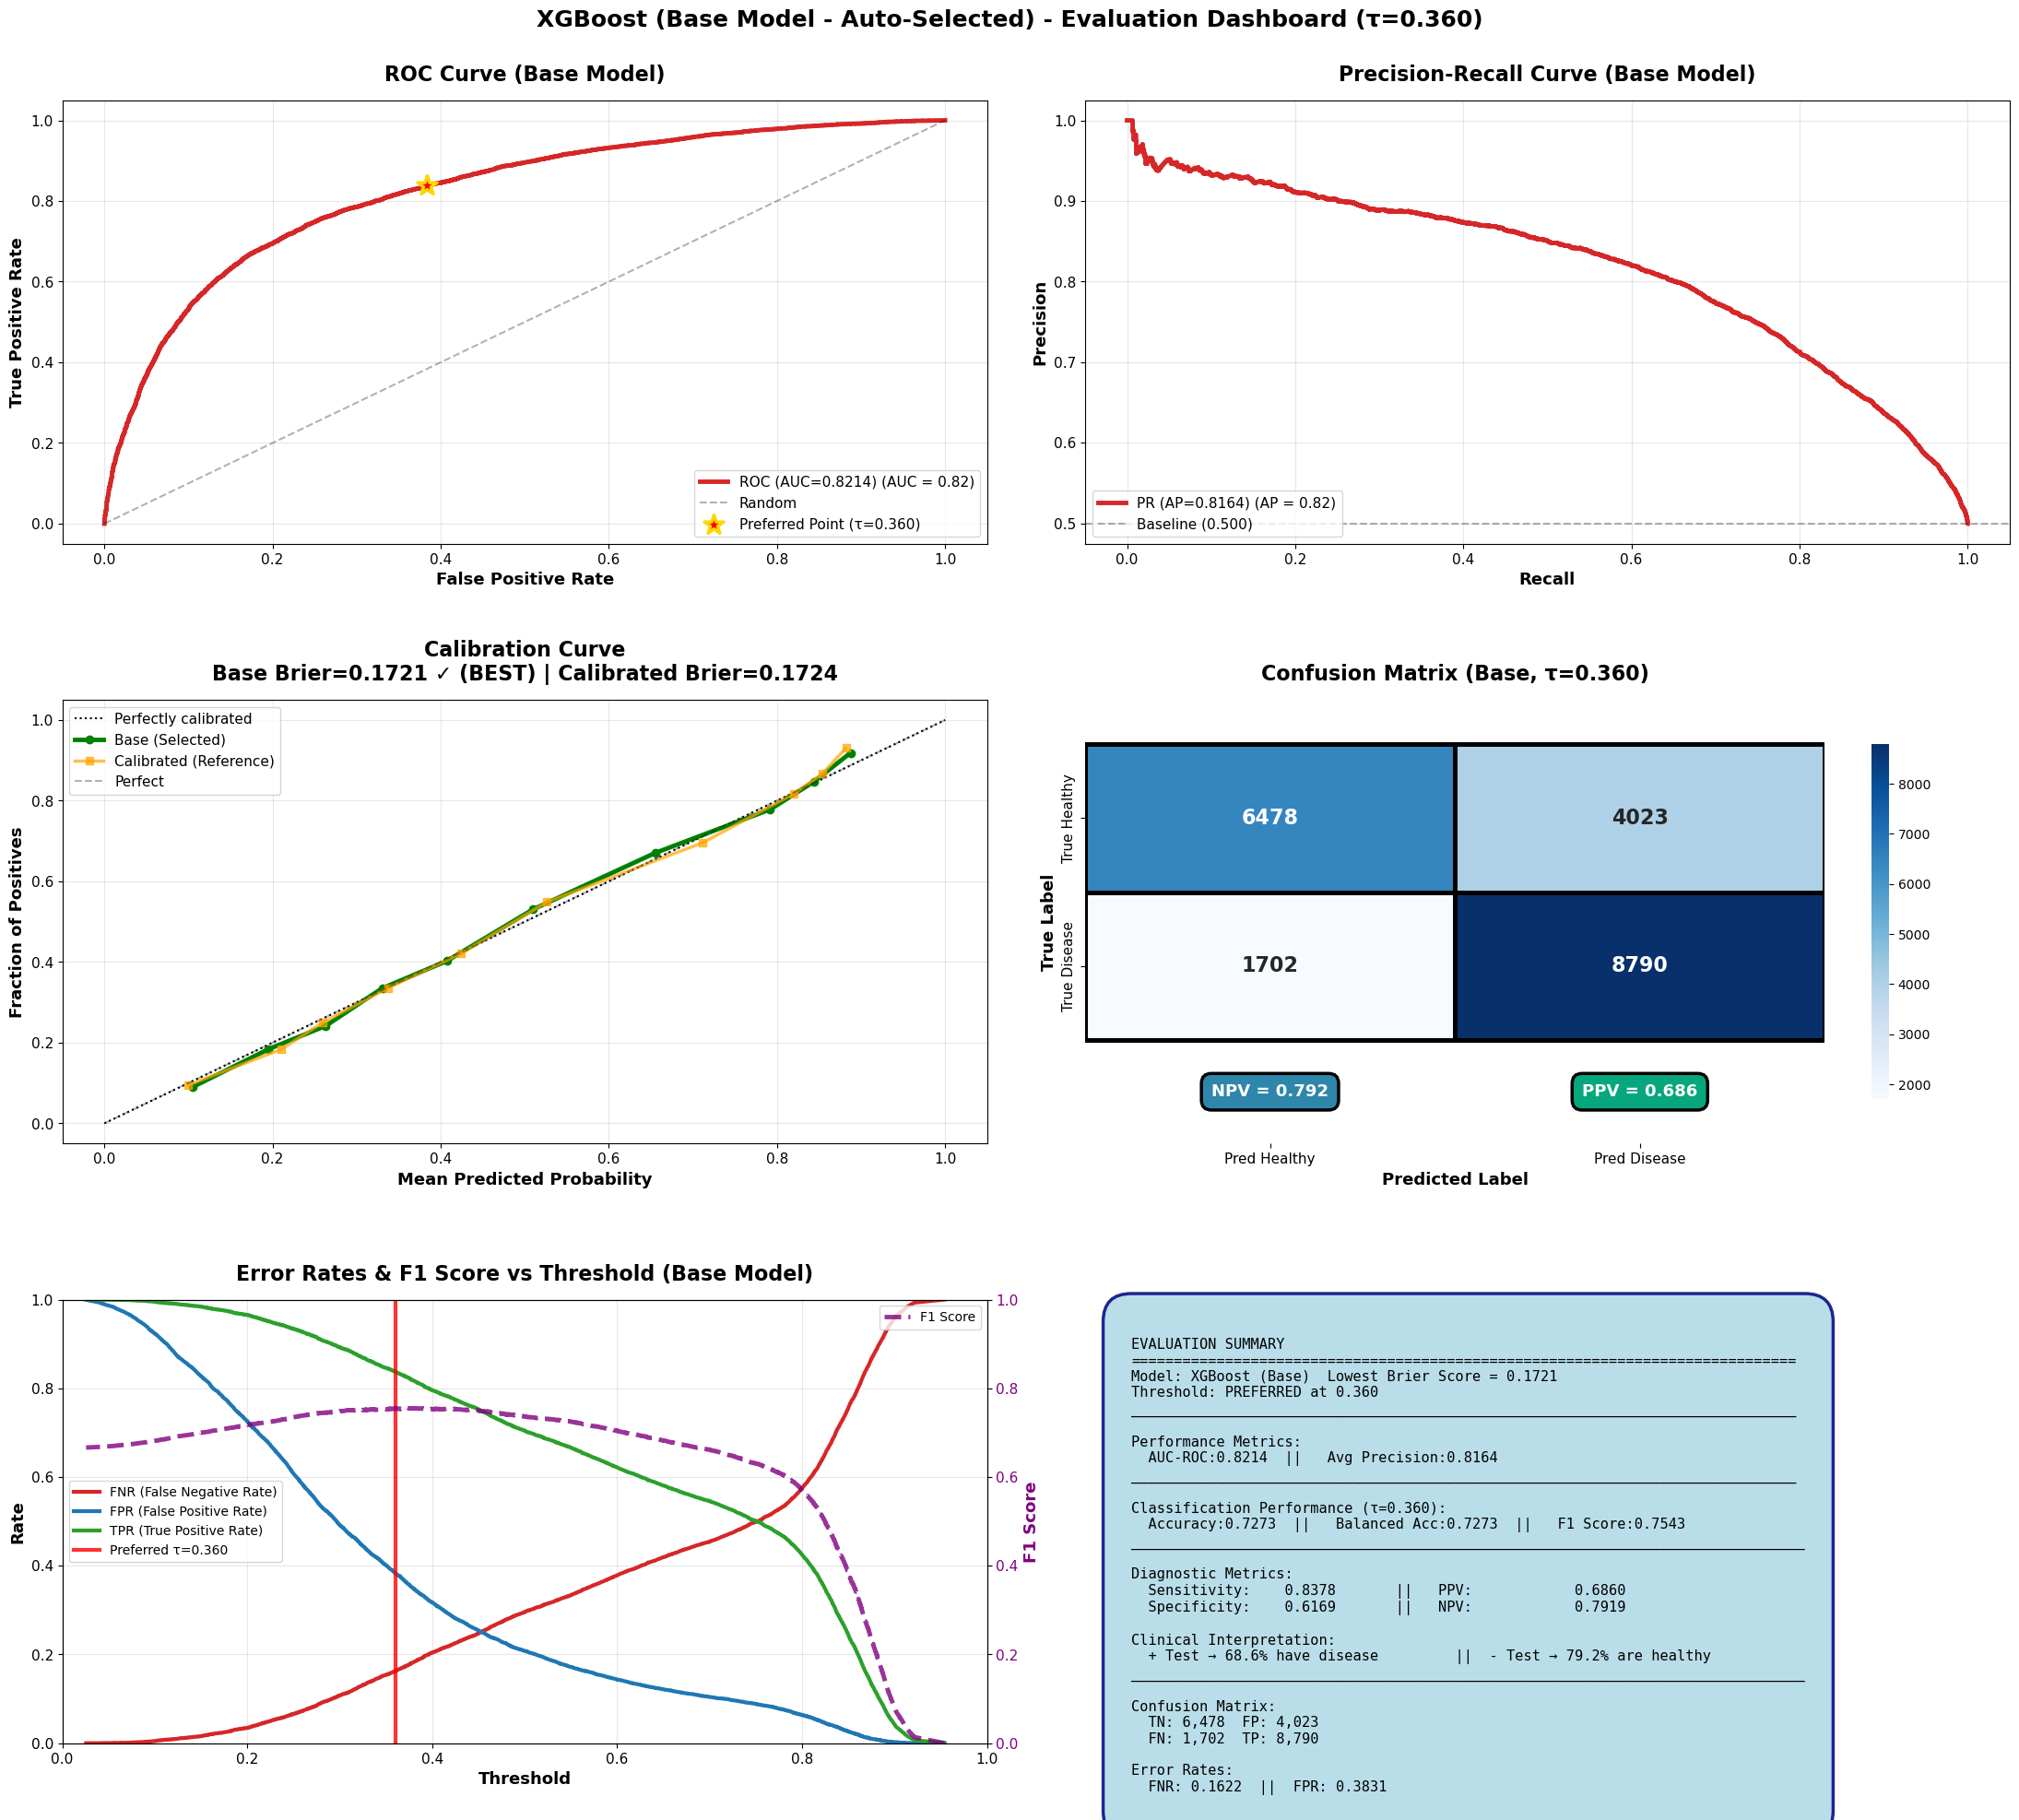


💾 Saving evaluation metrics...
✅ Saved: model_evaluation_metrics.json

EVALUATION COMPLETE
Selected Model:  Base (AUTO-SELECTED)
Selection:       Lower Brier Score (0.1721 < 0.1724)
Brier Score:     0.1721
Other Model:     Calibrated (Brier=0.1724)
Threshold:       0.360 (PREFERRED)
AUC-ROC:         0.8214
F1 Score:        0.7543
Sensitivity:     0.8378
Specificity:     0.6169
FNR:             0.1622
FPR:             0.3831



In [4]:
# ============================================================================
# PREFERRED THRESHOLD
# ============================================================================
PREFERRED_THRESHOLD = 0.36
print(f"🎯 Using PREFERRED threshold: {PREFERRED_THRESHOLD:.3f}\n")

# ============================================================================
# SETUP PATHS
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
data_dir = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
metrics_dir = REPORTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
metrics_dir.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD MODELS
# ============================================================================
model_path = MODEL_DIR / 'complete_model_package.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

print(f"📂 Loading: {model_path.name}")
artifacts = joblib.load(model_path)

# Extract models
base_model = artifacts.get('base_model', None)
calibrated_model = artifacts.get('calibrated_model', None)
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')

if base_model is None:
    raise ValueError("Base model not found in artifacts")

print(f"✓ Model Type: {model_type}")
print(f"✓ Preferred Threshold: {PREFERRED_THRESHOLD:.4f}")

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n📂 Loading test data...")
X_test = pd.read_parquet(data_dir / 'X_test.parquet')
y_test = pd.read_parquet(data_dir / 'y_test.parquet').iloc[:, 0].values

# Ensure feature order matches
if features:
    X_test = X_test[features]

print(f"✓ Test set size: {X_test.shape}")

# ============================================================================
# GENERATE PREDICTIONS FROM BOTH MODELS
# ============================================================================
print("\n🔄 Generating predictions from both models...")

# Base model predictions
y_prob_base = base_model.predict_proba(X_test)[:, 1]
brier_score_base = brier_score_loss(y_test, y_prob_base)

# Calibrated model predictions
if calibrated_model:
    y_prob_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
    brier_score_calibrated = brier_score_loss(y_test, y_prob_calibrated)
else:
    y_prob_calibrated = None
    brier_score_calibrated = None

print(f"\n📊 Brier Score Comparison:")
print(f"  Base Model:       {brier_score_base:.4f}")
if brier_score_calibrated is not None:
    print(f"  Calibrated Model: {brier_score_calibrated:.4f}")
    print(f"  Difference:       {abs(brier_score_base - brier_score_calibrated):.4f}")

# ============================================================================
# AUTO-SELECT MODEL WITH LOWEST BRIER SCORE (BEST CALIBRATION)
# ============================================================================
if brier_score_calibrated is not None:
    # Compare Brier scores - select model with LOWER (better) score
    if brier_score_calibrated < brier_score_base:
        selected_model = calibrated_model
        selected_model_name = "Calibrated"
        y_prob = y_prob_calibrated
        brier_score_selected = brier_score_calibrated
        other_model_name = "Base"
        y_prob_other = y_prob_base
        brier_score_other = brier_score_base
        selection_reason = f"Lower Brier Score ({brier_score_selected:.4f} < {brier_score_other:.4f})"
    elif brier_score_base < brier_score_calibrated:
        selected_model = base_model
        selected_model_name = "Base"
        y_prob = y_prob_base
        brier_score_selected = brier_score_base
        other_model_name = "Calibrated"
        y_prob_other = y_prob_calibrated
        brier_score_other = brier_score_calibrated
        selection_reason = f"Lower Brier Score ({brier_score_selected:.4f} < {brier_score_other:.4f})"
    else:
        # Scores are exactly equal - use calibrated as tiebreaker
        selected_model = calibrated_model
        selected_model_name = "Calibrated"
        y_prob = y_prob_calibrated
        brier_score_selected = brier_score_calibrated
        other_model_name = "Base"
        y_prob_other = y_prob_base
        brier_score_other = brier_score_base
        selection_reason = f"Equal Brier Score ({brier_score_selected:.4f}) - Calibrated selected as tiebreaker"
else:
    selected_model = base_model
    selected_model_name = "Base"
    y_prob = y_prob_base
    brier_score_selected = brier_score_base
    other_model_name = None
    y_prob_other = None
    brier_score_other = None
    selection_reason = "Only Base Model Available"

print(f"\n✅ SELECTED MODEL: {selected_model_name}")
print(f"   Selection Criterion: Lowest Brier Score (Best Calibration)")
print(f"   Reason: {selection_reason}")

# ============================================================================
# COMPUTE METRICS (using SELECTED model with PREFERRED threshold)
# ============================================================================
print(f"\n🔄 Computing metrics using {selected_model_name} model with threshold {PREFERRED_THRESHOLD:.3f}...")

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# PR curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Find index closest to preferred threshold
threshold_idx = np.argmin(np.abs(thresholds_roc - PREFERRED_THRESHOLD))

# Compute F1 scores across all thresholds
p = y_test.sum()
n = len(y_test) - p
fnr = 1 - tpr
tnr = 1 - fpr

tp = tpr * p
fp = fpr * n
fn = fnr * p
tn = tnr * n

denominator = (2 * tp + fp + fn)
f1_scores = np.divide(2 * tp, denominator, out=np.zeros_like(tp), where=denominator > 0)

# Compute metrics at PREFERRED threshold
y_pred = (y_prob >= PREFERRED_THRESHOLD).astype(int)
cm = confusion_matrix(y_test, y_pred)
tn_val, fp_val, fn_val, tp_val = cm.ravel()

sensitivity = tp_val / (tp_val + fn_val)
specificity = tn_val / (tn_val + fp_val)
ppv = tp_val / (tp_val + fp_val) if (tp_val + fp_val) > 0 else 0
npv = tn_val / (tn_val + fn_val) if (tn_val + fn_val) > 0 else 0
accuracy = (tp_val + tn_val) / len(y_test)
fpr_val = fp_val / (fp_val + tn_val)
fnr_val = fn_val / (fn_val + tp_val)
balanced_acc = (sensitivity + specificity) / 2
f1_at_threshold = f1_score(y_test, y_pred)

print("✓ Metrics computed")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n📊 Generating visualizations...")

fig, axes = plt.subplots(3, 2, figsize=(22, 20))
axes = axes.ravel()

# 1. ROC Curve
ax = axes[0]
RocCurveDisplay.from_predictions(y_test, y_prob, name=f'ROC (AUC={roc_auc:.4f})', 
                                 ax=ax, color='#d62728', lw=3.5)
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random')
ax.scatter(fpr[threshold_idx], tpr[threshold_idx], color='red', s=250, zorder=5,
           marker='*', edgecolors='gold', linewidths=2.5,
           label=f'Preferred Point (τ={PREFERRED_THRESHOLD:.3f})')
ax.set_title(f'ROC Curve ({selected_model_name} Model)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax = axes[1]
PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=f'PR (AP={avg_precision:.4f})', 
                                       ax=ax, color='#d62728', lw=3.5)
baseline = y_test.mean()
ax.axhline(baseline, color='k', linestyle='--', lw=1.5, alpha=0.3, 
           label=f'Baseline ({baseline:.3f})')
ax.set_title(f'Precision-Recall Curve ({selected_model_name} Model)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Calibration Curve (show both for comparison)
ax = axes[2]

# Plot selected model (primary)
CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, 
                                   strategy='quantile', ax=ax, 
                                   name=f'{selected_model_name} (Selected)', 
                                   color='green', marker='o', linewidth=3.5)

# Plot other model as reference if available
if y_prob_other is not None:
    CalibrationDisplay.from_predictions(y_test, y_prob_other, n_bins=10, 
                                       strategy='quantile', ax=ax, 
                                       name=f'{other_model_name} (Reference)', 
                                       color='orange', marker='s', linewidth=2.5, alpha=0.7)

# Perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Perfect')

# Title with Brier scores comparison
if brier_score_other is not None:
    title_text = f'Calibration Curve\n{selected_model_name} Brier={brier_score_selected:.4f} ✓ (BEST) | {other_model_name} Brier={brier_score_other:.4f}'
else:
    title_text = f'Calibration Curve ({selected_model_name} - Brier={brier_score_selected:.4f})'

ax.set_title(title_text, fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Mean Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# 4. Confusion Matrix with NPV and PPV
ax = axes[3]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pred Healthy', 'Pred Disease'],
            yticklabels=['True Healthy', 'True Disease'],
            annot_kws={"size": 16, "weight": "bold"},
            ax=ax, linewidths=2.5, linecolor='black',
            cbar_kws={'shrink': 0.8})
ax.set_title(f'Confusion Matrix ({selected_model_name}, τ={PREFERRED_THRESHOLD:.3f})', 
            fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)

# Add NPV and PPV labels
ax.text(0.5, 2.35, f'NPV = {npv:.3f}', fontsize=13, fontweight='bold', 
        ha='center', va='center', color='white',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#2E86AB', 
                 edgecolor='black', linewidth=2.5),
        transform=ax.transData)

ax.text(1.5, 2.35, f'PPV = {ppv:.3f}', fontsize=13, fontweight='bold', 
        ha='center', va='center', color='white',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#06A77D', 
                 edgecolor='black', linewidth=2.5),
        transform=ax.transData)

ax.set_ylim(2.7, -0.3)

# 5. Error Rates vs Threshold
ax = axes[4]
ax_twin = ax.twinx()

ax.plot(thresholds_roc, fnr, label='FNR (False Negative Rate)', lw=3, color='#d62728')
ax.plot(thresholds_roc, fpr, label='FPR (False Positive Rate)', lw=3, color='#1f77b4')
ax.plot(thresholds_roc, tpr, label='TPR (True Positive Rate)', lw=3, color='#2ca02c')

ax_twin.plot(thresholds_roc, f1_scores, label='F1 Score', 
            lw=3.5, color='purple', linestyle='--', alpha=0.8)
ax_twin.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='purple')
ax_twin.tick_params(axis='y', labelcolor='purple', labelsize=11)
ax_twin.set_ylim([0, 1])

ax.axvline(PREFERRED_THRESHOLD, color='red', linestyle='-', lw=3, alpha=0.8,
          label=f'Preferred τ={PREFERRED_THRESHOLD:.3f}')

ax.set_title(f'Error Rates & F1 Score vs Threshold ({selected_model_name} Model)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('Rate', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='center left', fontsize=10)
ax_twin.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# 6. Summary Text
ax = axes[5]
ax.axis('off')

# Color based on which model was selected
bg_color = 'lightgreen' if selected_model_name == 'Calibrated' else 'lightblue'

summary_text = f"""
EVALUATION SUMMARY
==============================================================================
Model: {model_type} ({selected_model_name})  Lowest Brier Score = {brier_score_selected:.4f}
Threshold: PREFERRED at {PREFERRED_THRESHOLD:.3f}
______________________________________________________________________________

Performance Metrics:
  AUC-ROC:{roc_auc:.4f}  ||   Avg Precision:{avg_precision:.4f}
______________________________________________________________________________

Classification Performance (τ={PREFERRED_THRESHOLD:.3f}):
  Accuracy:{accuracy:.4f}  ||   Balanced Acc:{balanced_acc:.4f}  ||   F1 Score:{f1_at_threshold:.4f}
_______________________________________________________________________________

Diagnostic Metrics:
  Sensitivity:    {sensitivity:.4f}       ||   PPV:            {ppv:.4f}
  Specificity:    {specificity:.4f}       ||   NPV:            {npv:.4f}

Clinical Interpretation:
  + Test → {ppv:.1%} have disease         ||  - Test → {npv:.1%} are healthy
_______________________________________________________________________________

Confusion Matrix:
  TN: {tn_val:5,}  FP: {fp_val:5,}
  FN: {fn_val:5,}  TP: {tp_val:5,}

Error Rates:
  FNR: {fnr_val:.4f}  ||  FPR: {fpr_val:.4f}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor=bg_color, 
                 alpha=0.85, edgecolor='navy', linewidth=2.5, pad=2))

plt.suptitle(f'{model_type} ({selected_model_name} Model - Auto-Selected) - Evaluation Dashboard (τ={PREFERRED_THRESHOLD:.3f})', 
             fontsize=18, fontweight='bold', y=0.998)

plt.tight_layout(h_pad=4.0, w_pad=3.5, rect=[0, 0, 1, 0.995])

output_path = FIGURES_DIR / f'01_performance_dashboard.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: {output_path.name}")
plt.show()
plt.close()

# ============================================================================
# SAVE METRICS
# ============================================================================
print("\n💾 Saving evaluation metrics...")

evaluation_metrics = {
    'model_info': {
        'model_type': model_type,
        'model_selected': selected_model_name.lower(),
        'selection_criterion': 'lowest_brier_score',
        'selection_reason': selection_reason,
        'n_features': len(features) if features else None,
        'threshold_type': 'preferred',
        'threshold_value': float(PREFERRED_THRESHOLD)
    },
    'model_comparison': {
        'base_brier_score': float(brier_score_base),
        'calibrated_brier_score': float(brier_score_calibrated) if brier_score_calibrated else None,
        'selected_brier_score': float(brier_score_selected),
        'brier_improvement': float(brier_score_other - brier_score_selected) if brier_score_other else None,
        'scores_equal': bool(abs(brier_score_calibrated - brier_score_base) < 1e-6) if brier_score_calibrated else False
    },
    'performance': {
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision),
        'brier_score': float(brier_score_selected),
        'threshold': float(PREFERRED_THRESHOLD),
        'f1_score': float(f1_at_threshold)
    },
    'classification_metrics': {
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv),
        'f1_score': float(f1_at_threshold),
        'fpr': float(fpr_val),
        'fnr': float(fnr_val)
    },
    'confusion_matrix': {
        'tn': int(tn_val),
        'fp': int(fp_val),
        'fn': int(fn_val),
        'tp': int(tp_val)
    },
    'test_set': {
        'n_samples': int(len(y_test)),
        'n_positive': int(y_test.sum()),
        'n_negative': int(len(y_test) - y_test.sum()),
        'prevalence': float(y_test.mean())
    }
}

metrics_file = metrics_dir / f'model_evaluation_metrics.json'
with open(metrics_file, 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print(f"✅ Saved: {metrics_file.name}")

# ============================================================================
# PRINT FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)
print(f"Selected Model:  {selected_model_name} (AUTO-SELECTED)")
print(f"Selection:       {selection_reason}")
print(f"Brier Score:     {brier_score_selected:.4f}")
if brier_score_other:
    print(f"Other Model:     {other_model_name} (Brier={brier_score_other:.4f})")
print(f"Threshold:       {PREFERRED_THRESHOLD:.3f} (PREFERRED)")
print(f"AUC-ROC:         {roc_auc:.4f}")
print(f"F1 Score:        {f1_at_threshold:.4f}")
print(f"Sensitivity:     {sensitivity:.4f}")
print(f"Specificity:     {specificity:.4f}")
print(f"FNR:             {fnr_val:.4f}")
print(f"FPR:             {fpr_val:.4f}")
print("="*70 + "\n")

### risk score analysis

⚡ Risk Scoring Analysis - Auto-Select Best Model (Brier Score)

Risk Boundaries: Low < 0.3 | Medium: 0.3-0.5 | High ≥ 0.5

[1/5] Loading data...
✓ Train: (48983, 13), Test: (20993, 13)

[2/5] Loading models and comparing Brier scores...
✓ Model Type: XGBoost
✓ Features aligned: 13

Comparing model performance...
  Base Model:       Brier Score = 0.1721
  Calibrated Model: Brier Score = 0.1724

✅ SELECTED: Base Model (Lower Brier Score: 0.1721)

[3/5] Generating risk scores with selected model...
✓ Train predictions: 48983
✓ Test predictions: 20993

[4/5] Creating df_risk_profiles...
✓ df_risk_profiles saved: (69976, 16)

[5/5] Computing statistics...

RISK GROUP SUMMARY - XGBoost (Base Model)
Selected by Brier Score: 0.1721
Low Risk: < 0.3 | Medium Risk: 0.3-0.5 | High Risk: ≥ 0.5
Dataset Risk_Group  Count  Percentage  Disease_Count  Disease_Rate  Avg_Probability  Min_Probability  Max_Probability
  Train        Low  14807   30.228855           2515     16.985210         0.191289       

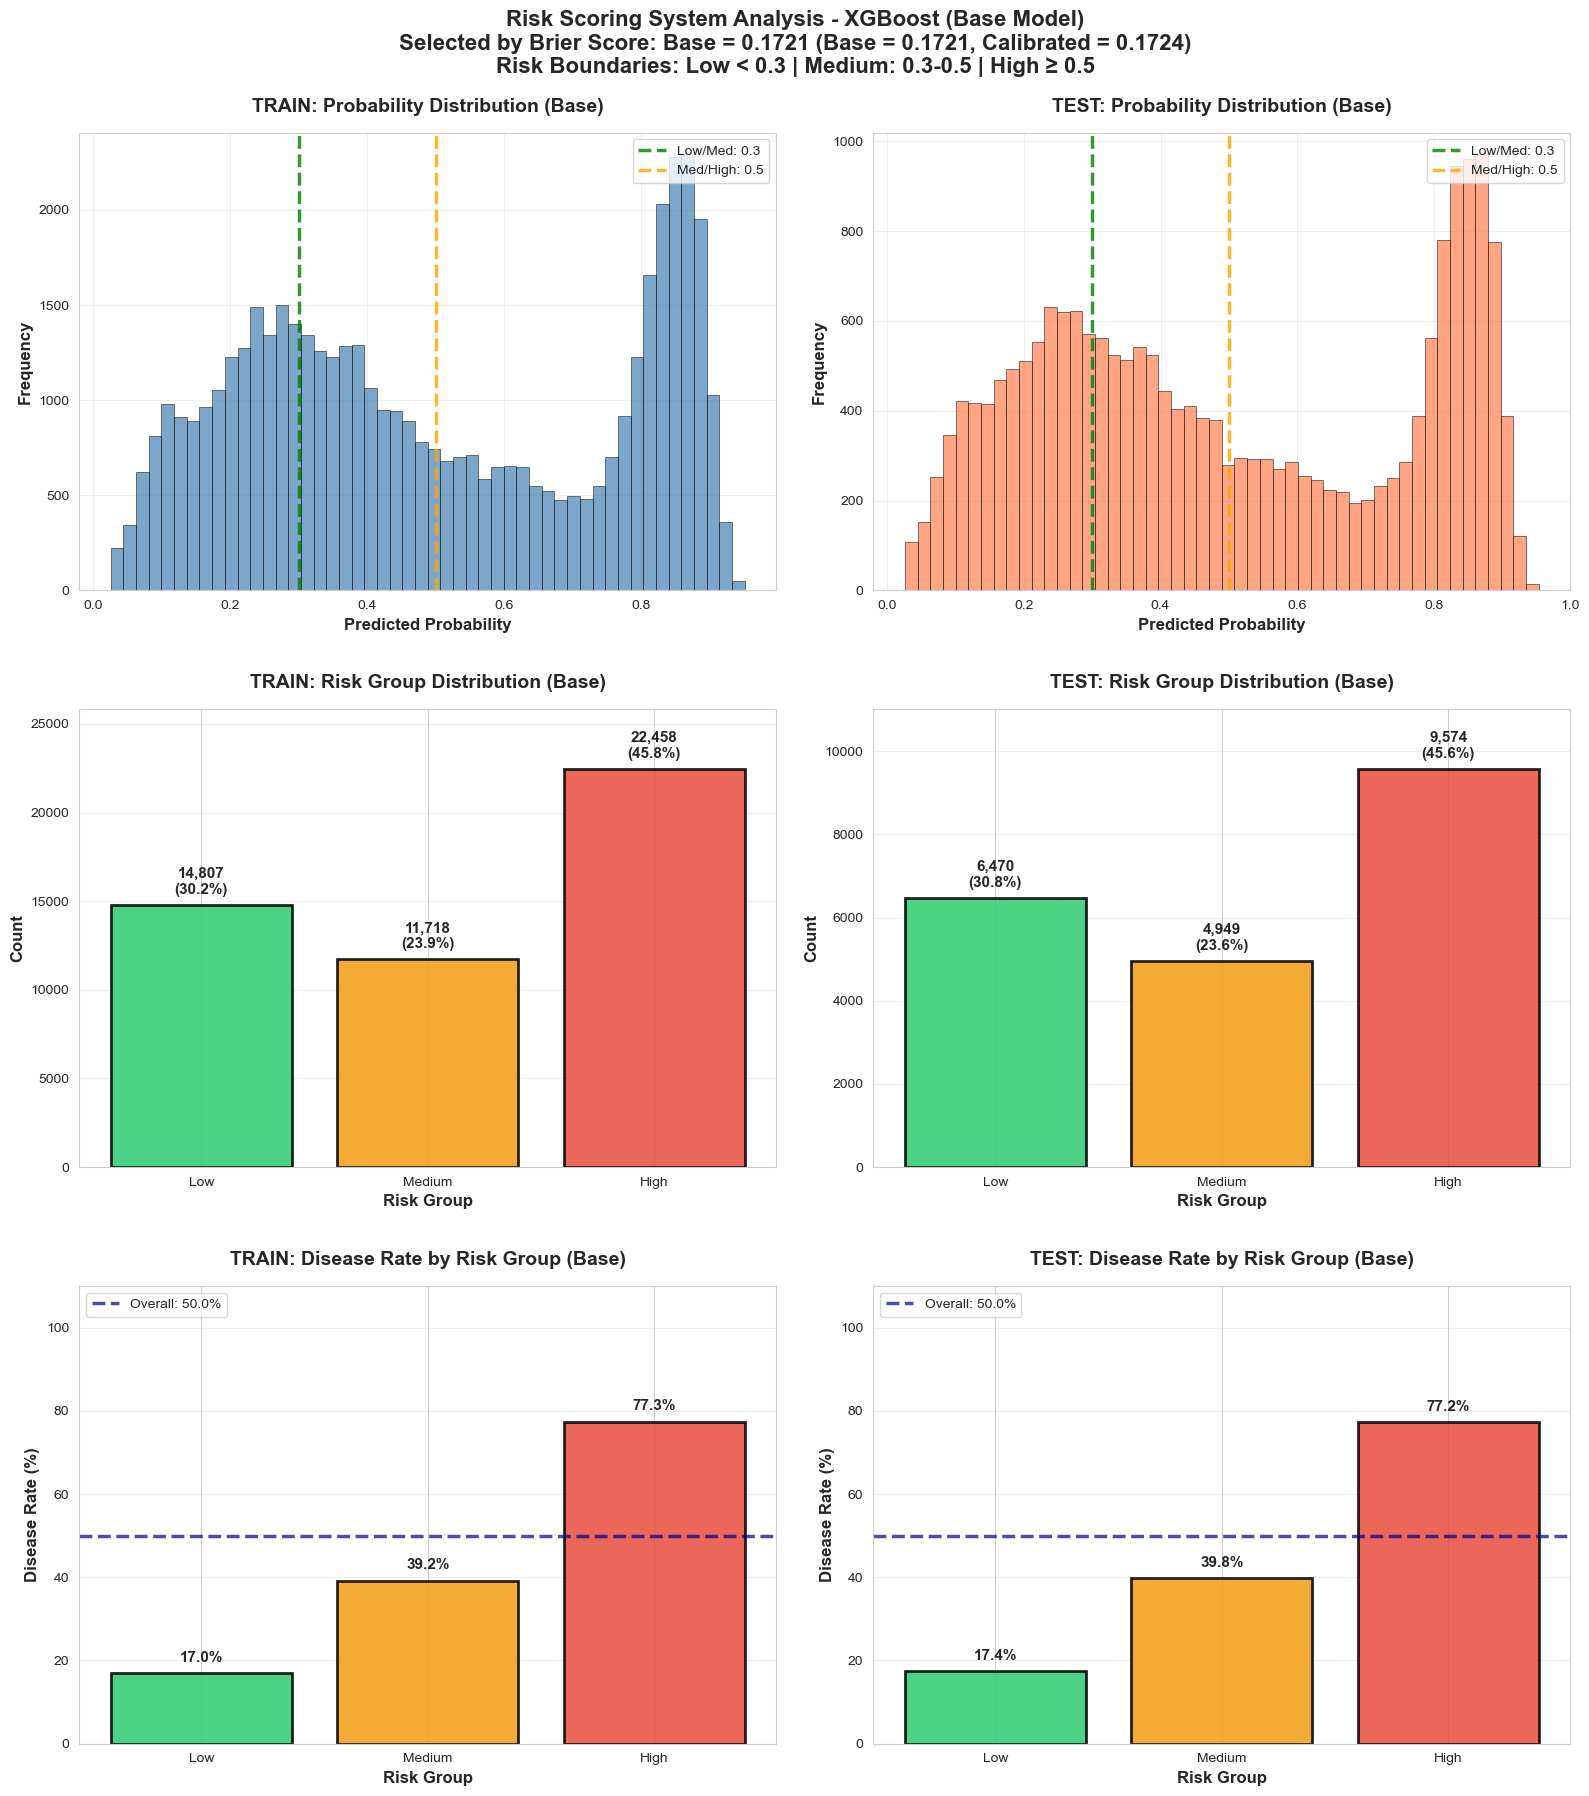


✅ Complete!

Final Selection: XGBoost (Base Model)
Brier Score: 0.1721


In [5]:
# ============================================================================
# RISK SCORING ANALYSIS - AUTO-SELECT BEST MODEL (BASE vs CALIBRATED)
# ============================================================================
print("⚡ Risk Scoring Analysis - Auto-Select Best Model (Brier Score)\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

THRESHOLD_LOW_MEDIUM = 0.30
THRESHOLD_MEDIUM_HIGH = 0.50

RISK_ORDER = ['Low', 'Medium', 'High']
RISK_COLORS = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}

print(f"Risk Boundaries: Low < {THRESHOLD_LOW_MEDIUM} | Medium: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High ≥ {THRESHOLD_MEDIUM_HIGH}")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'figures'

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[1/5] Loading data...")
X_train = pd.read_parquet(DATA_DIR / 'X_train.parquet')
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]
print(f"✓ Train: {X_train.shape}, Test: {X_test.shape}")

# ============================================================================
# LOAD MODELS & AUTO-SELECT BASED ON BRIER SCORE
# ============================================================================

print("\n[2/5] Loading models and comparing Brier scores...")
model_path = MODEL_DIR / 'complete_model_package.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract both models
base_model = artifacts.get('base_model', None)
calibrated_model = artifacts.get('calibrated_model', None)
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')

if base_model is None:
    raise ValueError("Base model not found in artifacts")

print(f"✓ Model Type: {model_type}")

# Ensure feature order matches
if features:
    X_train = X_train[features]
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

# Calculate predictions and Brier scores for both models
print("\nComparing model performance...")

# Base model
y_test_prob_base = base_model.predict_proba(X_test)[:, 1]
brier_base = brier_score_loss(y_test, y_test_prob_base)

# Calibrated model
if calibrated_model is not None:
    y_test_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]
    brier_cal = brier_score_loss(y_test, y_test_prob_cal)
else:
    y_test_prob_cal = None
    brier_cal = None

print(f"  Base Model:       Brier Score = {brier_base:.4f}")
if brier_cal is not None:
    print(f"  Calibrated Model: Brier Score = {brier_cal:.4f}")

# Select best model based on Brier score
if brier_cal is not None and brier_cal < brier_base:
    selected_model = calibrated_model
    selected_type = "Calibrated"
    selected_brier = brier_cal
    print(f"\n✅ SELECTED: Calibrated Model (Lower Brier Score: {brier_cal:.4f})")
else:
    selected_model = base_model
    selected_type = "Base"
    selected_brier = brier_base
    print(f"\n✅ SELECTED: Base Model (Lower Brier Score: {brier_base:.4f})")

# ============================================================================
# GENERATE PREDICTIONS & RISK CATEGORIES
# ============================================================================

def categorize_risk(probs, low_thresh=THRESHOLD_LOW_MEDIUM, high_thresh=THRESHOLD_MEDIUM_HIGH):
    """Categorize probabilities into Low/Medium/High risk groups"""
    cats = np.empty(len(probs), dtype=object)
    cats[probs < low_thresh] = 'Low'
    cats[(probs >= low_thresh) & (probs < high_thresh)] = 'Medium'
    cats[probs >= high_thresh] = 'High'
    return cats

print("\n[3/5] Generating risk scores with selected model...")
y_train_prob = selected_model.predict_proba(X_train)[:, 1]
y_test_prob = selected_model.predict_proba(X_test)[:, 1]

train_risk = categorize_risk(y_train_prob)
test_risk = categorize_risk(y_test_prob)

print(f"✓ Train predictions: {len(y_train_prob)}")
print(f"✓ Test predictions: {len(y_test_prob)}")

# ============================================================================
# CREATE df_risk_profiles
# ============================================================================

print("\n[4/5] Creating df_risk_profiles...")

# Combine all data
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)
risk_scores_full = np.concatenate([y_train_prob, y_test_prob])
risk_labels_full = np.concatenate([train_risk, test_risk])

# Create dataframe with all original columns + risk info
df_risk_profiles = X_full.copy()
df_risk_profiles['Actual_Disease'] = y_full.values
df_risk_profiles['Risk_Score'] = risk_scores_full
df_risk_profiles['Risk_Label'] = risk_labels_full

# Convert to categorical
df_risk_profiles['Risk_Label'] = pd.Categorical(
    df_risk_profiles['Risk_Label'], 
    categories=RISK_ORDER, 
    ordered=True
)

# Save
df_risk_profiles.to_parquet(METRICS_DIR / f'df_risk_profiles.parquet', index=False)

print(f"✓ df_risk_profiles saved: {df_risk_profiles.shape}")

# ============================================================================
# CREATE DATAFRAMES
# ============================================================================

scores = pd.DataFrame({
    'dataset': ['Train'] * len(y_train_prob) + ['Test'] * len(y_test_prob),
    'risk_score': np.concatenate([y_train_prob, y_test_prob]),
    'risk_group': np.concatenate([train_risk, test_risk]),
    'actual_disease': np.concatenate([y_train.values, y_test.values])
})

train_df = scores[scores['dataset'] == 'Train'].copy()
test_df = scores[scores['dataset'] == 'Test'].copy()

# ============================================================================
# COMPUTE STATISTICS
# ============================================================================

print("\n[5/5] Computing statistics...")
summary_stats = []

for dataset_name in ['Train', 'Test']:
    df = scores[scores['dataset'] == dataset_name]
    
    for risk_cat in RISK_ORDER:
        mask = df['risk_group'] == risk_cat
        
        if mask.sum() > 0:
            count = int(mask.sum())
            disease_count = int(df[mask]['actual_disease'].sum())
            disease_rate = float(df[mask]['actual_disease'].mean() * 100)
            avg_prob = float(df[mask]['risk_score'].mean())
            min_prob = float(df[mask]['risk_score'].min())
            max_prob = float(df[mask]['risk_score'].max())
            
            summary_stats.append({
                'Dataset': dataset_name,
                'Risk_Group': risk_cat,
                'Count': count,
                'Percentage': float(count / len(df) * 100),
                'Disease_Count': disease_count,
                'Disease_Rate': disease_rate,
                'Avg_Probability': avg_prob,
                'Min_Probability': min_prob,
                'Max_Probability': max_prob
            })

summary_df = pd.DataFrame(summary_stats)

# Print summary
print("\n" + "="*90)
print(f"RISK GROUP SUMMARY - {model_type} ({selected_type} Model)")
print(f"Selected by Brier Score: {selected_brier:.4f}")
print(f"Low Risk: < {THRESHOLD_LOW_MEDIUM} | Medium Risk: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High Risk: ≥ {THRESHOLD_MEDIUM_HIGH}")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# ============================================================================
# SAVE OUTPUTS
# ============================================================================

print("\nSaving outputs...")
scores.to_csv(METRICS_DIR / f'risk_scores.csv', index=False)
summary_df.to_csv(METRICS_DIR / f'risk_summary.csv', index=False)

# Save model selection info
import json
with open(METRICS_DIR / 'model_selection_info.json', 'w') as f:
    json.dump({
        'model_type': model_type,
        'selected_type': selected_type,
        'brier_scores': {
            'base': float(brier_base),
            'calibrated': float(brier_cal) if brier_cal is not None else None,
            'selected': float(selected_brier)
        },
        'selection_criterion': 'brier_score_lower_is_better'
    }, f, indent=2)

print(f"✓ Saved: risk_scores.csv")
print(f"✓ Saved: risk_summary.csv")
print(f"✓ Saved: model_selection_info.json")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating visualizations...")
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Create title with model selection info
fig_title = f'Risk Scoring System Analysis - {model_type} ({selected_type} Model)\n'
fig_title += f'Selected by Brier Score: {selected_type} = {selected_brier:.4f}'
if brier_cal is not None:
    fig_title += f' (Base = {brier_base:.4f}, Calibrated = {brier_cal:.4f})\n'
else:
    fig_title += f' (Base = {brier_base:.4f})\n'
fig_title += f'Risk Boundaries: Low < {THRESHOLD_LOW_MEDIUM} | Medium: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High ≥ {THRESHOLD_MEDIUM_HIGH}'

fig.suptitle(fig_title, fontsize=16, fontweight='bold', y=0.995)

# ============================================================================
# ROW 1: Probability Distributions
# ============================================================================

for idx, (df, title, color) in enumerate([
    (train_df, 'TRAIN', 'steelblue'), 
    (test_df, 'TEST', 'coral')
]):
    ax = axes[0, idx]
    
    # Histogram
    ax.hist(df['risk_score'], bins=50, alpha=0.7, color=color, 
            edgecolor='black', linewidth=0.5)
    
    # Threshold lines
    ax.axvline(THRESHOLD_LOW_MEDIUM, color='green', linestyle='--', 
               linewidth=2.5, alpha=0.8, label=f'Low/Med: {THRESHOLD_LOW_MEDIUM}')
    ax.axvline(THRESHOLD_MEDIUM_HIGH, color='orange', linestyle='--', 
               linewidth=2.5, alpha=0.8, label=f'Med/High: {THRESHOLD_MEDIUM_HIGH}')
    
    ax.set_title(f'{title}: Probability Distribution ({selected_type})', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3)

# ============================================================================
# ROW 2: Risk Group Distribution
# ============================================================================

for idx, (df, title) in enumerate([(train_df, 'TRAIN'), (test_df, 'TEST')]):
    ax = axes[1, idx]
    
    # Calculate counts
    counts = [df[df['risk_group'] == cat].shape[0] for cat in RISK_ORDER]
    
    # Bar chart
    bars = ax.bar(RISK_ORDER, counts, 
                  color=[RISK_COLORS[cat] for cat in RISK_ORDER],
                  edgecolor='black', linewidth=2, alpha=0.85)
    
    # Set y-axis limit
    max_count = max(counts)
    ax.set_ylim([0, max_count * 1.15])
    
    ax.set_title(f'{title}: Risk Group Distribution ({selected_type})', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add labels
    for bar, count in zip(bars, counts):
        pct = count / len(df) * 100
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max_count * 0.02,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

# ============================================================================
# ROW 3: Disease Rate by Risk Group
# ============================================================================

for idx, (df, title) in enumerate([(train_df, 'TRAIN'), (test_df, 'TEST')]):
    ax = axes[2, idx]
    
    # Calculate disease rates
    disease_rates = [df[df['risk_group'] == cat]['actual_disease'].mean() * 100 
                     for cat in RISK_ORDER]
    
    # Bar chart
    bars = ax.bar(RISK_ORDER, disease_rates, 
                  color=[RISK_COLORS[cat] for cat in RISK_ORDER],
                  edgecolor='black', linewidth=2, alpha=0.85)
    
    ax.set_title(f'{title}: Disease Rate by Risk Group ({selected_type})', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
    ax.set_ylabel('Disease Rate (%)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 110])
    ax.grid(alpha=0.3, axis='y')
    
    # Add labels
    for bar, rate in zip(bars, disease_rates):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Overall baseline
    overall = df['actual_disease'].mean() * 100
    ax.axhline(overall, color='darkblue', linestyle='--', linewidth=2.5, alpha=0.7,
               label=f'Overall: {overall:.1f}%')
    ax.legend(fontsize=10, loc='upper left')

# ============================================================================
# SAVE FIGURE
# ============================================================================

plt.tight_layout(h_pad=3.0, w_pad=2.0)

output_path = FIGURES_DIR / f'02_risk_scoring_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {output_path.name}")
plt.show()
plt.close()

print("\n✅ Complete!")
print(f"\nFinal Selection: {model_type} ({selected_type} Model)")
print(f"Brier Score: {selected_brier:.4f}")

### Shap barplot

⚡ SHAP Feature Importance Analysis - Auto-Select Best Model

[1/5] Loading data...
✓ Test data: (20993, 13)

[2/5] Loading models and selecting best...
✓ Model Type: XGBoost
✓ Features aligned: 13

Calculating Brier scores...

Brier Score Comparison:
  Base Model:       0.1721
  Calibrated Model: 0.1724

✅ Best Model (by Brier Score): Base

📝 Note: Using BASE model for SHAP analysis
   (TreeExplainer requires unwrapped model; feature importances are identical)

[3/5] Subsampling to 6000 samples...
✓ Sample size: (6000, 13)

[4/5] Computing SHAP values (this may take a few minutes)...
✓ Using TreeExplainer
✓ SHAP values computed: (6000, 13)

[5/5] Computing feature impacts...
✓ Top 20 features identified

Saving results...
✓ Saved: shap_feature_importance.csv

Creating visualization...

✓ Saved: 03_shap_bidirectional_importance.png


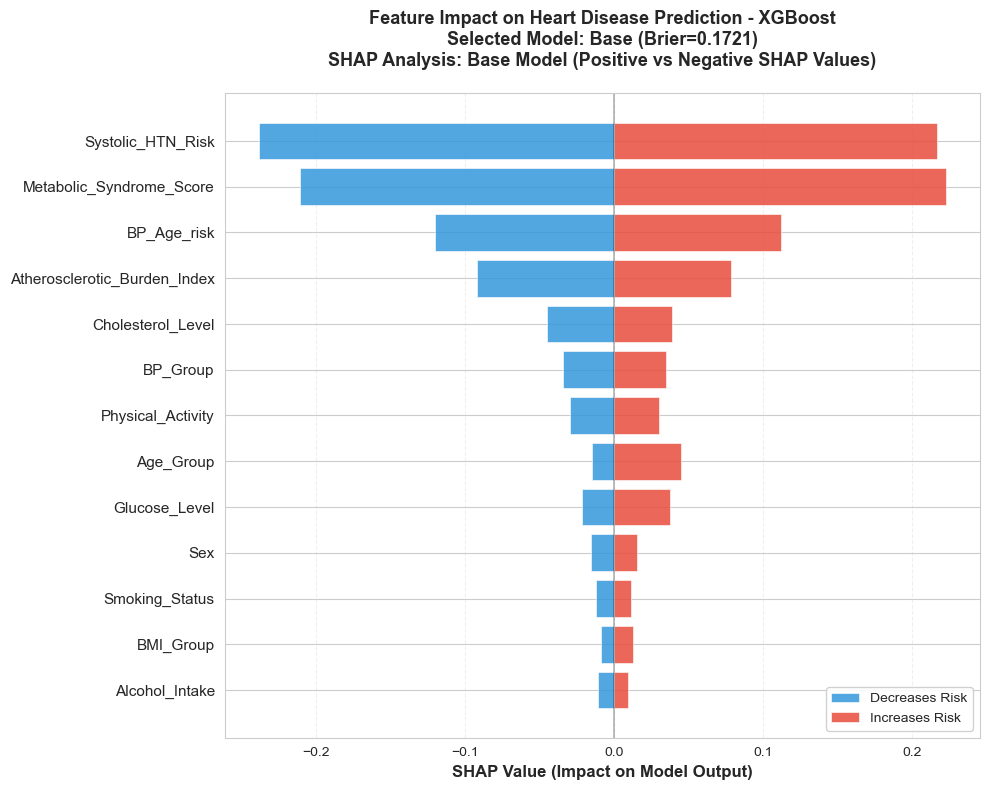

In [6]:
# ============================================================================
# SHAP FEATURE IMPORTANCE ANALYSIS - AUTO-SELECT BEST MODEL
# ============================================================================
import shap


print("⚡ SHAP Feature Importance Analysis - Auto-Select Best Model\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'
METRICS_DIR = REPORTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("[1/5] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
print(f"✓ Test data: {X_test.shape}")

# ============================================================================
# LOAD MODELS & AUTO-SELECT
# ============================================================================

print("\n[2/5] Loading models and selecting best...")
model_path = MODEL_DIR / 'complete_model_package.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract models and metadata
base_model = artifacts.get('base_model', None)
calibrated_model = artifacts.get('calibrated_model', None)
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')
brier_scores = artifacts.get('brier_scores', {})

if base_model is None:
    raise ValueError("Base model not found in artifacts")

print(f"✓ Model Type: {model_type}")

# Ensure feature order matches
if features:
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

# Convert to float32 for SHAP
X_test = X_test.astype('float32')

# Calculate Brier scores if not already in artifacts
if not brier_scores:
    print("\nCalculating Brier scores...")
    y_test_prob_base = base_model.predict_proba(X_test)[:, 1]
    brier_base = brier_score_loss(y_test, y_test_prob_base)
    
    if calibrated_model is not None:
        y_test_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]
        brier_cal = brier_score_loss(y_test, y_test_prob_cal)
    else:
        brier_cal = None
    
    brier_scores = {
        'base': brier_base,
        'calibrated': brier_cal,
        'selected': brier_base if brier_cal is None or brier_base < brier_cal else brier_cal
    }
else:
    brier_base = brier_scores.get('base')
    brier_cal = brier_scores.get('calibrated')

print(f"\nBrier Score Comparison:")
print(f"  Base Model:       {brier_base:.4f}")
if brier_cal is not None:
    print(f"  Calibrated Model: {brier_cal:.4f}")

# Determine which was selected
if brier_cal is not None and brier_cal < brier_base:
    selected_type = "Calibrated"
    selected_brier = brier_cal
else:
    selected_type = "Base"
    selected_brier = brier_base

print(f"\n✅ Best Model (by Brier Score): {selected_type}")

# IMPORTANT: Always use base model for SHAP
# Reason: TreeExplainer needs direct access to tree structure
# Calibration wraps the model but doesn't change feature importances
shap_model = base_model
print(f"\n📝 Note: Using BASE model for SHAP analysis")
print(f"   (TreeExplainer requires unwrapped model; feature importances are identical)")

# ============================================================================
# SUBSAMPLE DATA
# ============================================================================

print(f"\n[3/5] Subsampling to {SAMPLE_SIZE} samples...")

if len(X_test) > SAMPLE_SIZE:
    _, X_sample, _, _ = train_test_split(
        X_test, y_test,
        test_size=SAMPLE_SIZE/len(X_test),
        stratify=y_test,
        random_state=RANDOM_STATE
    )
else:
    X_sample = X_test.copy()

print(f"✓ Sample size: {X_sample.shape}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/5] Computing SHAP values (this may take a few minutes)...")

# Use TreeExplainer for tree-based models
try:
    explainer = shap.TreeExplainer(shap_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    print("   Trying KernelExplainer...")
    try:
        explainer = shap.KernelExplainer(shap_model.predict_proba, shap.sample(X_sample, 100))
        print("✓ Using KernelExplainer")
    except:
        explainer = shap.Explainer(shap_model, X_sample)
        print("✓ Using default Explainer")

shap_values_obj = explainer(X_sample)

# Extract SHAP values for positive class (disease)
if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values
    # For binary classification, get positive class
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2:
        # Check if it's already the right shape or needs slicing
        if shap_values.shape[1] == len(features):
            # Already correct shape (n_samples, n_features)
            pass
        else:
            # Has 2 outputs, take second one
            shap_values = shap_values[:, 1]
else:
    shap_values = shap_values_obj

# Ensure correct shape
if len(shap_values.shape) == 1:
    # Reshape if needed
    shap_values = shap_values.reshape(-1, len(features))

print(f"✓ SHAP values computed: {shap_values.shape}")

feature_names = X_test.columns.tolist()

# ============================================================================
# COMPUTE FEATURE IMPACTS
# ============================================================================

print("\n[5/5] Computing feature impacts...")

shap_positive = np.where(shap_values > 0, shap_values, 0).mean(axis=0)
shap_negative = np.where(shap_values < 0, shap_values, 0).mean(axis=0)
shap_total = np.abs(shap_values).mean(axis=0)

shap_summary = pd.DataFrame({
    'feature': feature_names,
    'positive_impact': shap_positive,
    'negative_impact': shap_negative,
    'total_impact': shap_total
})

top_features = shap_summary.nlargest(20, 'total_impact').sort_values('total_impact')

print(f"✓ Top 20 features identified")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\nSaving results...")

summary_path = METRICS_DIR / f'shap_feature_importance.csv'
shap_summary.sort_values('total_impact', ascending=False).to_csv(summary_path, index=False)

print(f"✓ Saved: {summary_path.name}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating visualization...")

fig, ax = plt.subplots(figsize=(10, 8))

y_positions = np.arange(len(top_features))

ax.barh(y_positions, top_features['negative_impact'], 
        color='#3498db', alpha=0.85, label='Decreases Risk',
        edgecolor='white', linewidth=0.5)

ax.barh(y_positions, top_features['positive_impact'], 
        color='#e74c3c', alpha=0.85, label='Increases Risk',
        edgecolor='white', linewidth=0.5)

ax.set_yticks(y_positions)
ax.set_yticklabels(top_features['feature'], fontsize=11)
ax.set_xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')

# Title shows selected model info
title = f'Feature Impact on Heart Disease Prediction - {model_type}\n'
title += f'Selected Model: {selected_type} (Brier={selected_brier:.4f})\n'
title += f'SHAP Analysis: Base Model (Positive vs Negative SHAP Values)'

ax.set_title(title, fontsize=13, fontweight='bold', pad=20)

ax.axvline(x=0, color='black', linewidth=1.2, alpha=0.3)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()

output_path = FIGURES_DIR / f'03_shap_bidirectional_importance.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"\n✓ Saved: {output_path.name}")

plt.show()
plt.close()

### shap dot plot

⚡ SHAP Dot Plot Analysis - Auto-Select Best Model

[1/4] Loading data...
✓ Test data: (20993, 13)

[2/4] Loading models and selecting best...
✓ Model Type: XGBoost
✓ Features aligned: 13

Calculating Brier scores...

Brier Score Comparison:
  Base Model:       0.1721
  Calibrated Model: 0.1724

✅ Best Model (by Brier Score): Base

📝 Note: Using BASE model for SHAP analysis
   (TreeExplainer requires unwrapped model)

[3/4] Subsampling to 6000 samples...
✓ Sample size: (6000, 13)

[4/4] Computing SHAP values (this may take a few minutes)...
✓ Using TreeExplainer
✓ SHAP values computed: (6000, 13)

Creating SHAP dot plot...

✓ Saved: 04_shap_dot_plot.png


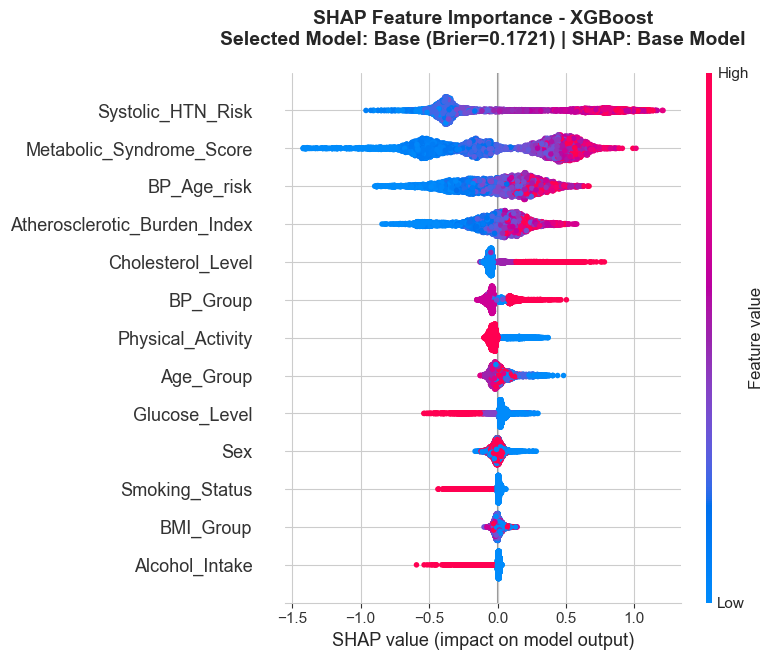

In [7]:
# ============================================================================
# SHAP DOT PLOT ANALYSIS - AUTO-SELECT BEST MODEL
# ============================================================================
print("⚡ SHAP Dot Plot Analysis - Auto-Select Best Model\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'figures'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("[1/4] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]
print(f"✓ Test data: {X_test.shape}")

# ============================================================================
# LOAD MODELS & AUTO-SELECT
# ============================================================================

print("\n[2/4] Loading models and selecting best...")
model_path = MODEL_DIR / 'complete_model_package.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract models and metadata
base_model = artifacts.get('base_model', None)
calibrated_model = artifacts.get('calibrated_model', None)
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')
brier_scores = artifacts.get('brier_scores', {})

if base_model is None:
    raise ValueError("Base model not found in artifacts")

print(f"✓ Model Type: {model_type}")

# Ensure feature order matches
if features:
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

# Calculate Brier scores if not already in artifacts
if not brier_scores:
    print("\nCalculating Brier scores...")
    y_test_prob_base = base_model.predict_proba(X_test)[:, 1]
    brier_base = brier_score_loss(y_test, y_test_prob_base)
    
    if calibrated_model is not None:
        y_test_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]
        brier_cal = brier_score_loss(y_test, y_test_prob_cal)
    else:
        brier_cal = None
    
    brier_scores = {
        'base': brier_base,
        'calibrated': brier_cal,
        'selected': brier_base if brier_cal is None or brier_base < brier_cal else brier_cal
    }
else:
    brier_base = brier_scores.get('base')
    brier_cal = brier_scores.get('calibrated')

print(f"\nBrier Score Comparison:")
print(f"  Base Model:       {brier_base:.4f}")
if brier_cal is not None:
    print(f"  Calibrated Model: {brier_cal:.4f}")

# Determine which was selected
if brier_cal is not None and brier_cal < brier_base:
    selected_type = "Calibrated"
    selected_brier = brier_cal
else:
    selected_type = "Base"
    selected_brier = brier_base

print(f"\n✅ Best Model (by Brier Score): {selected_type}")

# IMPORTANT: Always use base model for SHAP
shap_model = base_model
print(f"\n📝 Note: Using BASE model for SHAP analysis")
print(f"   (TreeExplainer requires unwrapped model)")

# ============================================================================
# SUBSAMPLE DATA
# ============================================================================

print(f"\n[3/4] Subsampling to {SAMPLE_SIZE} samples...")

if len(X_test) > SAMPLE_SIZE:
    _, X_sample, _, _ = train_test_split(
        X_test, y_test,
        test_size=SAMPLE_SIZE / len(X_test),
        stratify=y_test,
        random_state=RANDOM_STATE
    )
else:
    X_sample = X_test.copy()

print(f"✓ Sample size: {X_sample.shape}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/4] Computing SHAP values (this may take a few minutes)...")

try:
    explainer = shap.TreeExplainer(shap_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    print("   Trying alternative explainer...")
    try:
        explainer = shap.KernelExplainer(shap_model.predict_proba, shap.sample(X_sample, 100))
        print("✓ Using KernelExplainer")
    except:
        explainer = shap.Explainer(shap_model, X_sample)
        print("✓ Using default Explainer")

shap_values_obj = explainer(X_sample)

# Extract SHAP values for positive class (disease)
if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2:
        # Check if it's already the right shape or needs slicing
        if shap_values.shape[1] == len(features):
            # Already correct shape (n_samples, n_features)
            pass
        else:
            # Has 2 outputs, take second one
            shap_values = shap_values[:, 1]
else:
    shap_values = shap_values_obj

# Ensure correct shape
if len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(-1, len(features))

print(f"✓ SHAP values computed: {shap_values.shape}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating SHAP dot plot...")

fig, ax = plt.subplots(figsize=(12, 10))

shap.summary_plot(
    shap_values,
    X_sample,
    plot_type='dot',
    max_display=20,
    show=False
)

# Add title with model selection info
title = f'SHAP Feature Importance - {model_type}\n'
title += f'Selected Model: {selected_type} (Brier={selected_brier:.4f}) | SHAP: Base Model'

plt.title(title, fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

output_path = FIGURES_DIR / f'04_shap_dot_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"\n✓ Saved: {output_path.name}")

plt.show()
plt.close()

### SHAP Waterfall Plot: Individual Patient Risk Explanation

⚡ Individual Patient SHAP Analysis - Auto-Select Best Model

[1/5] Loading models and selecting best...
✓ Model Type: XGBoost

[2/5] Loading data...
✓ Features aligned: 13
✓ Test samples: 20993

Calculating Brier scores...

✅ Best Model (by Brier Score): Base
   Brier Score: 0.1721
📝 SHAP Analysis: Base Model (TreeExplainer requirement)
✓ Risk scores loaded: 20993 test samples

[3/5] Selecting random patient...
✓ Patient index: 19177
✓ Actual outcome: Disease
✓ Risk group: High

[4/5] Computing SHAP values...
✓ Using TreeExplainer
✓ SHAP values computed

[5/5] Creating visualization...


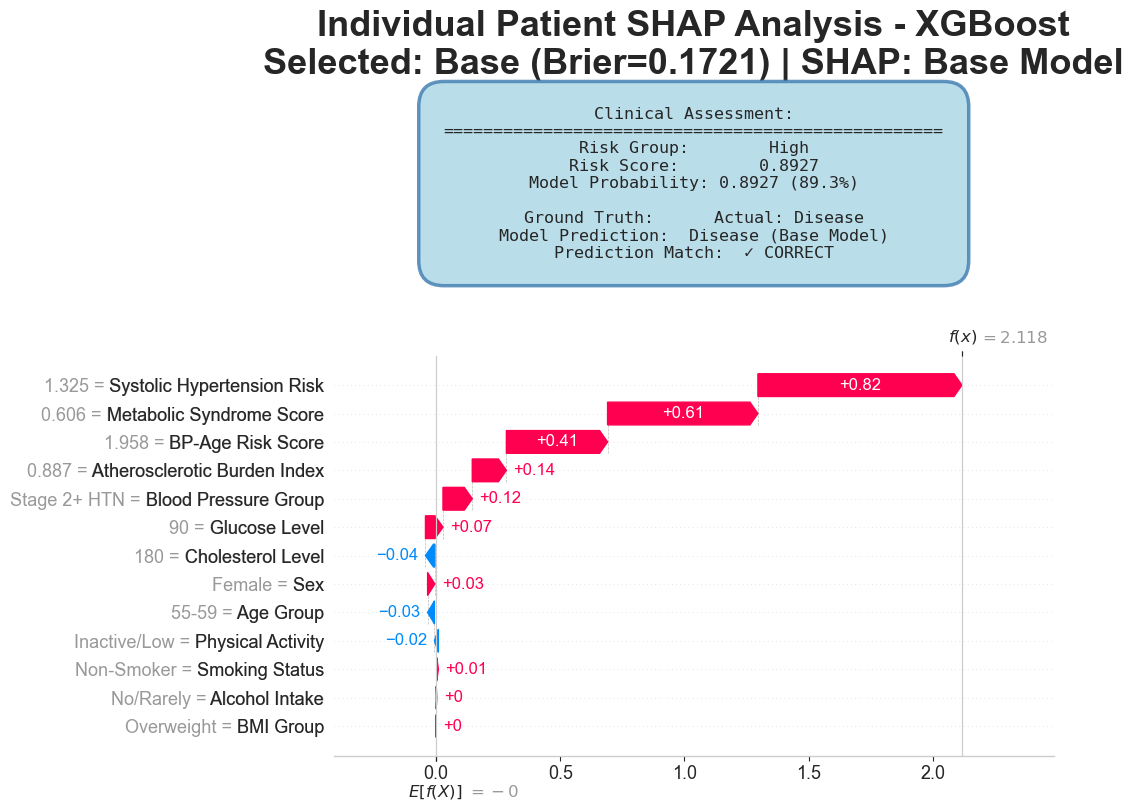

In [8]:
import time

# ============================================================================
# INDIVIDUAL PATIENT SHAP ANALYSIS - AUTO-SELECT BEST MODEL
# ============================================================================
print("⚡ Individual Patient SHAP Analysis - Auto-Select Best Model\n")

# ============================================================================
# CONFIGURATION - FEATURE MAPPINGS
# ============================================================================

# Feature names mapping (clean display names)
FEATURE_NAME_MAPPING = {
    # Original features
    'Sex': 'Sex',
    'Cholesterol_Level': 'Cholesterol Level',
    'Glucose_Level': 'Glucose Level',
    'Smoking_Status': 'Smoking Status',
    'Alcohol_Intake': 'Alcohol Intake',
    'Physical_Activity': 'Physical Activity',
    'Age_Group': 'Age Group',
    'BP_Group': 'Blood Pressure Group',
    'BMI_Group': 'BMI Group',
    
    # Engineered features
    'BP_Age_risk': 'BP-Age Risk Score',
    'Metabolic_Syndrome_Score': 'Metabolic Syndrome Score',
    'Systolic_HTN_Risk': 'Systolic Hypertension Risk',
    'Atherosclerotic_Burden_Index': 'Atherosclerotic Burden Index'
}

# Categorical feature value mappings (value -> text label)
CATEGORICAL_MAPPINGS = {
    # Binary/Ordinal features
    'Sex': {1: 'Female', 2: 'Male'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {1: 'Non-Smoker', 2: 'Smoker'},
    'Alcohol_Intake': {1: 'No/Rarely', 2: 'Yes/Regularly'},
    'Physical_Activity': {1: 'Active', 2: 'Inactive/Low'},
    
    # Grouped features
    'Age_Group': {1: '<40', 2: '40-44', 3: '45-49', 4: '50-54', 5: '55-59', 6: '60-64', 7: '65-69', 8: '70+'},
    'BMI_Group': {1: 'Normal/Underweight', 2: 'Overweight', 3: 'Obese I', 4: 'Obese II/III'},
    'BP_Group': {1: 'Normal', 2: 'Elevated', 3: 'Stage 1 HTN', 4: 'Stage 2+ HTN'},
}

# ============================================================================
# LAYOUT CONFIGURATION
# ============================================================================

FIGURE_WIDTH = 40
FIGURE_HEIGHT = 50
TITLE_FONTSIZE = 26
BOX_FONTSIZE = 12
OUTPUT_DPI = 300

TITLE_HEIGHT_RATIO = 0.015
BOX_HEIGHT_RATIO = 0.03
GRAPH_HEIGHT_RATIO = 0.50
GAP_TITLE_TO_BOX = 0.15
GAP_BOX_TO_GRAPH = 0.20
MARGIN_TOP = 0.05
MARGIN_BOTTOM = 0.055

TITLE_X, TITLE_WIDTH = 0.05, 0.9
BOX_X, BOX_WIDTH = 0.15, 0.70
WATERFALL_X, WATERFALL_WIDTH = 0.05, 0.9

TITLE_Y = 1.0 - MARGIN_TOP - TITLE_HEIGHT_RATIO
BOX_Y = TITLE_Y - GAP_TITLE_TO_BOX - BOX_HEIGHT_RATIO
WATERFALL_Y = MARGIN_BOTTOM

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'figures'

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD MODELS & AUTO-SELECT
# ============================================================================

print("[1/5] Loading models and selecting best...")
model_path = MODEL_DIR / 'complete_model_package.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract models and metadata
base_model = artifacts.get('base_model', None)
calibrated_model = artifacts.get('calibrated_model', None)
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')
brier_scores = artifacts.get('brier_scores', {})

if base_model is None:
    raise ValueError("Base model not found in artifacts")

print(f"✓ Model Type: {model_type}")

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[2/5] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values

# Remove target column if present
if 'target' in X_test.columns:
    X_test = X_test.drop('target', axis=1)

# Ensure feature order matches
if features:
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

print(f"✓ Test samples: {len(X_test)}")

# Calculate Brier scores if not in artifacts
if not brier_scores:
    print("\nCalculating Brier scores...")
    y_test_prob_base = base_model.predict_proba(X_test)[:, 1]
    brier_base = brier_score_loss(y_test, y_test_prob_base)
    
    if calibrated_model is not None:
        y_test_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]
        brier_cal = brier_score_loss(y_test, y_test_prob_cal)
    else:
        brier_cal = None
    
    brier_scores = {
        'base': brier_base,
        'calibrated': brier_cal,
        'selected': brier_base if brier_cal is None or brier_base < brier_cal else brier_cal
    }
else:
    brier_base = brier_scores.get('base')
    brier_cal = brier_scores.get('calibrated')

# Determine selected model
if brier_cal is not None and brier_cal < brier_base:
    selected_type = "Calibrated"
    selected_brier = brier_cal
    prediction_model = calibrated_model
else:
    selected_type = "Base"
    selected_brier = brier_base
    prediction_model = base_model

print(f"\n✅ Best Model (by Brier Score): {selected_type}")
print(f"   Brier Score: {selected_brier:.4f}")

# SHAP always uses base model
shap_model = base_model
print(f"📝 SHAP Analysis: Base Model (TreeExplainer requirement)")

# Load risk scores
risk_scores_path = METRICS_DIR / 'risk_scores.csv'
if not risk_scores_path.exists():
    raise FileNotFoundError(f"Risk scores not found: {risk_scores_path}")

risk_scores = pd.read_csv(risk_scores_path)
test_risk_scores = risk_scores[risk_scores['dataset'] == 'Test'].reset_index(drop=True)
print(f"✓ Risk scores loaded: {len(test_risk_scores)} test samples")

# ============================================================================
# SELECT RANDOM PATIENT
# ============================================================================

print("\n[3/5] Selecting random patient...")
random_seed = int(time.time() * 1000) % 2**32
np.random.seed(random_seed)
random_idx = np.random.randint(0, len(X_test))

sample_row = X_test.iloc[random_idx]
actual_outcome = y_test[random_idx]

# Get risk info for this patient (using selected model for prediction)
patient_prob = prediction_model.predict_proba(X_test.iloc[[random_idx]])[:, 1][0]
risk_score = test_risk_scores.iloc[random_idx]['risk_score']
risk_group = test_risk_scores.iloc[random_idx]['risk_group']

print(f"✓ Patient index: {random_idx}")
print(f"✓ Actual outcome: {'Disease' if actual_outcome == 1 else 'Healthy'}")
print(f"✓ Risk group: {risk_group}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/5] Computing SHAP values...")
try:
    explainer = shap.TreeExplainer(shap_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    explainer = shap.Explainer(shap_model, X_test)
    print("✓ Using default Explainer")

shap_values_obj = explainer(X_test.iloc[[random_idx]])

if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values[0]
    if len(shap_values.shape) == 2:
        shap_values = shap_values[:, 1]
    base_value = shap_values_obj.base_values[0]
    if isinstance(base_value, np.ndarray):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]
else:
    shap_values = shap_values_obj[0]
    base_value = explainer.expected_value
    if isinstance(base_value, np.ndarray):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]

print("✓ SHAP values computed")

# ============================================================================
# DECODE FEATURE VALUES FOR DISPLAY
# ============================================================================

feature_list = X_test.columns.tolist()
decoded_data = []

for feat in feature_list:
    value = sample_row[feat]
    
    # Check if feature is categorical and has a mapping
    if feat in CATEGORICAL_MAPPINGS:
        # Convert to text label
        int_value = int(round(value))
        decoded_data.append(CATEGORICAL_MAPPINGS[feat].get(int_value, str(int_value)))
    else:
        # Continuous features: format with appropriate precision
        if abs(value) >= 100:
            decoded_data.append(f"{value:.1f}")
        elif abs(value) >= 10:
            decoded_data.append(f"{value:.2f}")
        else:
            decoded_data.append(f"{value:.3f}")

# Apply clean feature names
clean_names = [FEATURE_NAME_MAPPING.get(f, f) for f in feature_list]

# ============================================================================
# CREATE SHAP EXPLANATION
# ============================================================================

# Use patient_prob from selected model
actual_label = 'Disease' if actual_outcome == 1 else 'Healthy'
predicted_label = 'Disease' if patient_prob >= 0.5 else 'Healthy'
is_correct = (patient_prob >= 0.5) == actual_outcome

shap_exp = shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=np.array(decoded_data),
    feature_names=clean_names
)

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n[5/5] Creating visualization...")

fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# Title
ax_title = fig.add_axes([TITLE_X, TITLE_Y, TITLE_WIDTH, TITLE_HEIGHT_RATIO])
ax_title.axis('off')

title_text = f'Individual Patient SHAP Analysis - {model_type}\n'
title_text += f'Selected: {selected_type} (Brier={selected_brier:.4f}) | SHAP: Base Model'
ax_title.text(0.5, 0.5, title_text,
              fontsize=TITLE_FONTSIZE, fontweight='bold', ha='center', va='center')

# Clinical Assessment Box
ax_box = fig.add_axes([BOX_X, BOX_Y, BOX_WIDTH, BOX_HEIGHT_RATIO])
ax_box.axis('off')

clinical_text = f"""Clinical Assessment:
{"="*50}
Risk Group:        {risk_group}
Risk Score:        {risk_score:.4f}
Model Probability: {patient_prob:.4f} ({patient_prob*100:.1f}%)

Ground Truth:      Actual: {actual_label}
Model Prediction:  {predicted_label} ({selected_type} Model)
Prediction Match:  {'✓ CORRECT' if is_correct else '✗ INCORRECT'}"""

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.85, 
             edgecolor='steelblue', linewidth=2.5, pad=1.5)
ax_box.text(0.5, 0.5, clinical_text, transform=ax_box.transAxes, 
            fontsize=BOX_FONTSIZE, ha='center', va='center', bbox=props, family='monospace')

# SHAP Waterfall Plot
ax_waterfall = fig.add_axes([WATERFALL_X, WATERFALL_Y, WATERFALL_WIDTH, GRAPH_HEIGHT_RATIO])
plt.sca(ax_waterfall)

total_features = len(shap_exp.values)
shap.plots.waterfall(shap_exp, max_display=total_features, show=False)

ax_waterfall.grid(False)
ax_waterfall.set_axisbelow(False)
plt.suptitle(' ', fontsize=1)

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_path = FIGURES_DIR / f'05_individual_patient_shap_analysis.png'
plt.savefig(output_path, dpi=OUTPUT_DPI, bbox_inches='tight', pad_inches=0.3)

plt.show()
plt.close()


📂 Loading model and data...
✓ Model: XGBoost (base)
✓ Threshold: 0.360
✓ Test set: 20,993 samples

🔄 Generating predictions...
✓ Predictions generated

📊 Computing Decision Curve Analysis...
  ✅ DCA Computed:
     Net Benefit at τ=0.360: 0.3109
     Treat All Net Benefit: 0.2184
     Model Superior: ✅ YES

  📊 Creating Decision Curve Analysis visualization...
  ✅ Saved: dca_curve.png


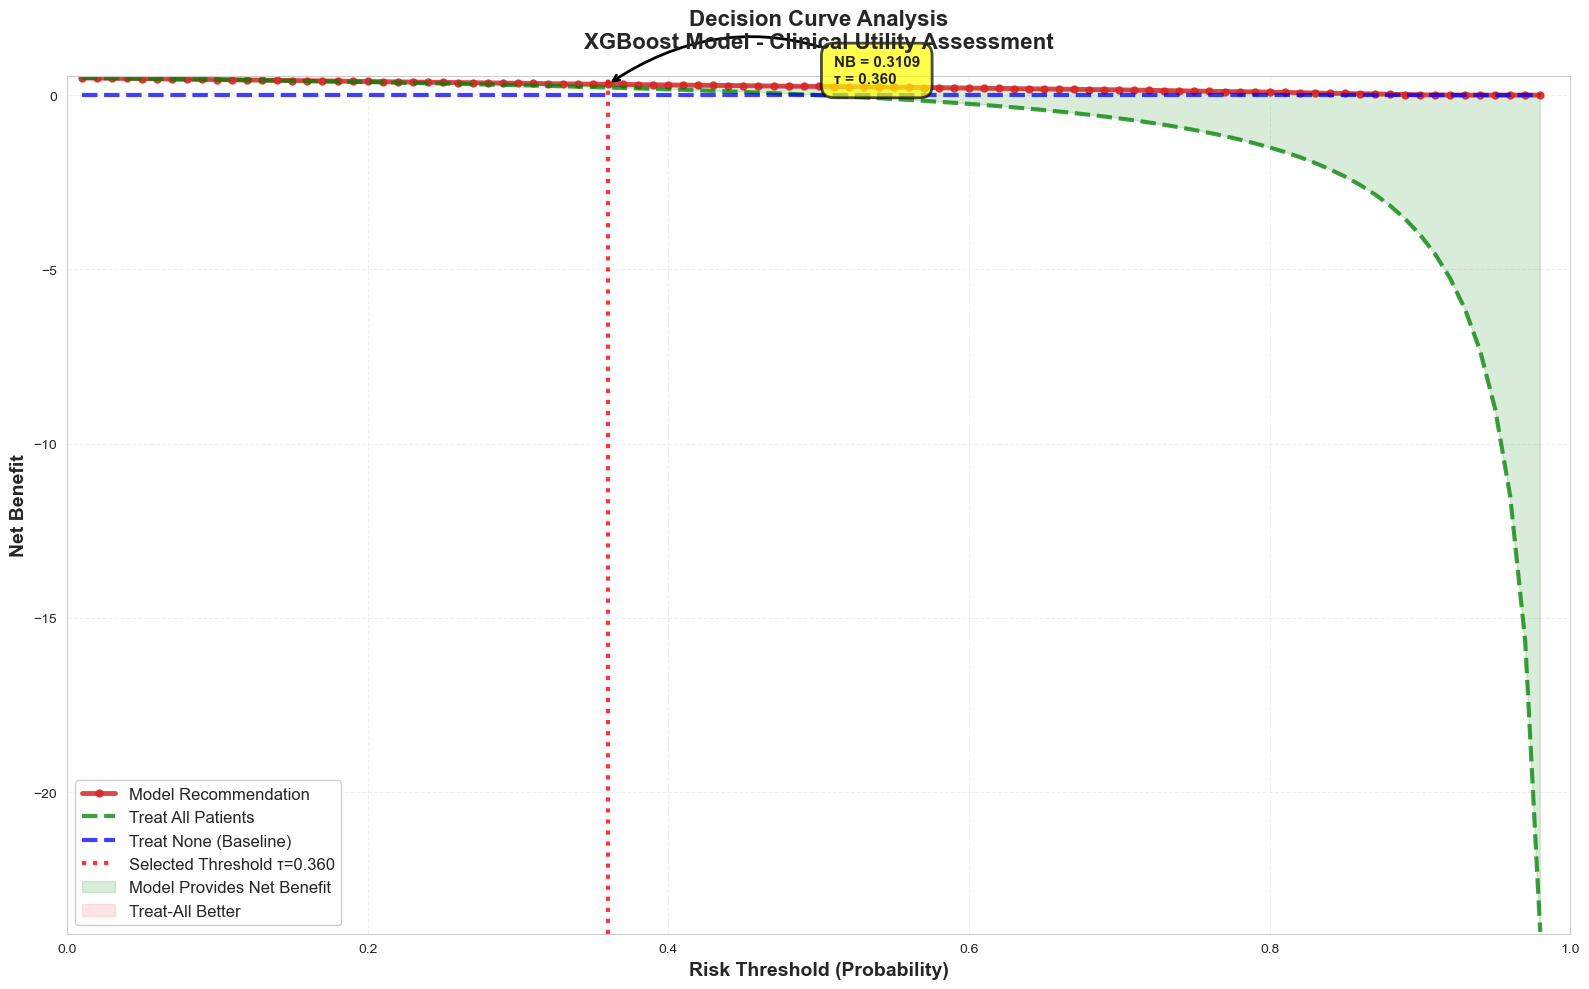


  📋 DCA Interpretation Summary:
  Threshold    Model NB        Treat All NB       Recommendation                
  0.100        0.4460          0.4442             ≈ Similar                     
  0.200        0.3917          0.3747             ✅ Use Model                   
  0.300        0.3407          0.2854             ✅ Use Model                   
  0.360        0.3109          0.2184             ✅ Use Model                    ← SELECTED
  0.500        0.2481          -0.0004            ✅ Use Model                   
  0.700        0.1514          -0.6674            ✅ Use Model                   

  ✅ Saved: dca_metrics.csv

📈 DCA Summary:
  Disease Prevalence: 50.0%
  Total Patients: 20,993
  Net Benefit Improvement: 0.0925
  Interpretation: At threshold 0.360, model provides net benefit of 0.3109. ✅ Model is superior to treat-all strategy (treat-all net benefit: 0.2184). This translates to 9.3 additional net benefit per 100 patients screened.

✅ DECISION CURVE ANALYSIS COMPLET

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# LOAD SAVED MODEL & DATA
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'
data_dir = PROJECT_ROOT / 'artifacts' / 'split data sets'

print("\n📂 Loading model and data...")

# Load the complete model package
package = joblib.load(MODEL_DIR / 'complete_model_package.pkl')

# Load test data
X_test = pd.read_parquet(data_dir / 'X_test.parquet')
y_test = pd.read_parquet(data_dir / 'y_test.parquet').iloc[:, 0].values

# Get the selected model
selected_model = package['selected_model']
threshold = package['threshold']

print(f"✓ Model: {package['model_type']} ({package['selected_type']})")
print(f"✓ Threshold: {threshold:.3f}")
print(f"✓ Test set: {len(y_test):,} samples")

# ============================================================================
# GENERATE PREDICTIONS
# ============================================================================
print("\n🔄 Generating predictions...")
selected_proba = selected_model.predict_proba(X_test)[:, 1]
print(f"✓ Predictions generated")

# ============================================================================
# DECISION CURVE ANALYSIS (DCA)
# ============================================================================
print("\n📊 Computing Decision Curve Analysis...")

def calculate_dca(y_true, y_pred_proba, threshold_start=0.01, threshold_end=0.99, step=0.01):
    """
    Calculate Decision Curve Analysis metrics
    
    Net Benefit = (TP/N) - (FP/N) × (threshold/(1-threshold))
    """
    thresholds_dca = np.arange(threshold_start, threshold_end, step)
    net_benefit_model = []
    net_benefit_treat_all = []
    net_benefit_treat_none = []
    
    n_total = len(y_true)
    n_disease = np.sum(y_true)
    n_healthy = n_total - n_disease
    disease_prevalence = n_disease / n_total
    
    for threshold_val in thresholds_dca:
        # Model predictions at this threshold
        y_pred = (y_pred_proba >= threshold_val).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Net Benefit: (TP/N) - (FP/N) × (threshold/(1-threshold))
        if threshold_val < 1.0:
            net_benefit = (tp / n_total) - (fp / n_total) * (threshold_val / (1 - threshold_val))
        else:
            net_benefit = 0
        net_benefit_model.append(net_benefit)
        
        # Net Benefit Treat All
        treat_all_benefit = (n_disease / n_total) - (n_healthy / n_total) * (threshold_val / (1 - threshold_val)) if threshold_val < 1.0 else 0
        net_benefit_treat_all.append(treat_all_benefit)
        
        # Net Benefit Treat None
        net_benefit_treat_none.append(0)
    
    return (thresholds_dca, np.array(net_benefit_model), 
            np.array(net_benefit_treat_all), np.array(net_benefit_treat_none),
            n_disease, n_healthy, disease_prevalence)

# Calculate DCA
dca_thresholds, nb_model, nb_treat_all, nb_treat_none, n_dis, n_healthy, prev = calculate_dca(
    y_test, selected_proba, threshold_start=0.01, threshold_end=0.99, step=0.01
)

# Net benefit at selected threshold
selected_idx_dca = np.argmin(np.abs(dca_thresholds - threshold))
nb_at_selected = nb_model[selected_idx_dca]
nb_treat_all_at_selected = nb_treat_all[selected_idx_dca]

print(f"  ✅ DCA Computed:")
print(f"     Net Benefit at τ={threshold:.3f}: {nb_at_selected:.4f}")
print(f"     Treat All Net Benefit: {nb_treat_all_at_selected:.4f}")
print(f"     Model Superior: {'✅ YES' if nb_at_selected > nb_treat_all_at_selected else '⚠️ NO'}")

# ============================================================================
# DCA VISUALIZATION
# ============================================================================
print("\n  📊 Creating Decision Curve Analysis visualization...")

fig, ax = plt.subplots(figsize=(16, 10))

# Plot curves
ax.plot(dca_thresholds, nb_model, label='Model Recommendation', 
        lw=3.5, color='#d62728', marker='o', markersize=5, alpha=0.85)
ax.plot(dca_thresholds, nb_treat_all, label='Treat All Patients', 
        lw=3, color='green', linestyle='--', alpha=0.75)
ax.plot(dca_thresholds, nb_treat_none, label='Treat None (Baseline)', 
        lw=3, color='blue', linestyle='--', alpha=0.75)

# Highlight selected threshold
ax.axvline(threshold, color='red', linestyle=':', lw=3, alpha=0.8,
          label=f'Selected Threshold τ={threshold:.3f}')

# Shade regions
ax.fill_between(dca_thresholds, nb_model, nb_treat_all, 
                where=(nb_model >= nb_treat_all), 
                color='green', alpha=0.15, label='Model Provides Net Benefit')
ax.fill_between(dca_thresholds, nb_model, nb_treat_all, 
                where=(nb_model < nb_treat_all), 
                color='red', alpha=0.1, label='Treat-All Better')

# Styling
ax.set_xlabel('Risk Threshold (Probability)', fontsize=14, fontweight='bold')
ax.set_ylabel('Net Benefit', fontsize=14, fontweight='bold')
ax.set_title(f'Decision Curve Analysis\n{package["model_type"]} Model - Clinical Utility Assessment', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=12, loc='best', framealpha=0.95)
ax.set_xlim([0, 1])
ax.set_ylim([min(nb_treat_all.min(), nb_model.min()) - 0.05, 
             max(nb_treat_all.max(), nb_model.max()) + 0.05])

# Annotation at selected threshold
ax.annotate(
    f'NB = {nb_at_selected:.4f}\nτ = {threshold:.3f}',
    xy=(threshold, nb_at_selected),
    xytext=(threshold + 0.15, nb_at_selected + 0.05),
    fontsize=11, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.7, edgecolor='black', linewidth=2),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', lw=2, color='black')
)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'dca_curve.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"  ✅ Saved: dca_curve.png")
plt.show()
plt.close()

# ============================================================================
# DCA INTERPRETATION TABLE
# ============================================================================
print("\n  📋 DCA Interpretation Summary:")
print(f"  " + "="*75)
print(f"  {'Threshold':<12} {'Model NB':<15} {'Treat All NB':<18} {'Recommendation':<30}")
print(f"  " + "="*75)

key_thresholds = [0.10, 0.20, 0.30, threshold, 0.50, 0.70]
for kt in key_thresholds:
    idx_kt = np.argmin(np.abs(dca_thresholds - kt))
    kt_actual = dca_thresholds[idx_kt]
    nb_kt = nb_model[idx_kt]
    nb_ta_kt = nb_treat_all[idx_kt]
    
    if nb_kt > nb_ta_kt + 0.01:
        rec = "✅ Use Model"
    elif nb_kt < nb_ta_kt - 0.01:
        rec = "⚠️ Treat All Better"
    else:
        rec = "≈ Similar"
    
    marker = " ← SELECTED" if abs(kt_actual - threshold) < 0.02 else ""
    print(f"  {kt_actual:<12.3f} {nb_kt:<15.4f} {nb_ta_kt:<18.4f} {rec:<30}{marker}")

print(f"  " + "="*75)

# ============================================================================
# SAVE DCA METRICS
# ============================================================================
dca_df = pd.DataFrame({
    'threshold': dca_thresholds,
    'model_net_benefit': nb_model,
    'treat_all_net_benefit': nb_treat_all,
    'treat_none_net_benefit': nb_treat_none
})
dca_df.to_csv(MODEL_DIR / 'dca_metrics.csv', index=False)
print(f"\n  ✅ Saved: dca_metrics.csv")

# ============================================================================
# DCA SUMMARY STATISTICS
# ============================================================================
dca_summary = {
    'disease_prevalence': float(prev),
    'n_disease': int(n_dis),
    'n_healthy': int(n_healthy),
    'n_total': len(y_test),
    'selected_threshold': float(threshold),
    'net_benefit_at_selected': float(nb_at_selected),
    'treat_all_net_benefit_at_selected': float(nb_treat_all_at_selected),
    'model_superior': bool(nb_at_selected > nb_treat_all_at_selected),
    'net_benefit_improvement': float(nb_at_selected - nb_treat_all_at_selected),
    'interpretation': (
        f"At threshold {threshold:.3f}, model provides net benefit of {nb_at_selected:.4f}. "
        f"{'✅ Model is superior to treat-all strategy' if nb_at_selected > nb_treat_all_at_selected else '⚠️ Treat-all strategy is superior'} "
        f"(treat-all net benefit: {nb_treat_all_at_selected:.4f}). "
        f"This translates to {abs(nb_at_selected - nb_treat_all_at_selected)*100:.1f} additional net benefit per 100 patients screened."
    )
}

print(f"\n📈 DCA Summary:")
print(f"  Disease Prevalence: {prev*100:.1f}%")
print(f"  Total Patients: {len(y_test):,}")
print(f"  Net Benefit Improvement: {dca_summary['net_benefit_improvement']:.4f}")
print(f"  Interpretation: {dca_summary['interpretation']}")

# ============================================================================
# FINAL MESSAGE
# ============================================================================
print("\n" + "="*75)
print("✅ DECISION CURVE ANALYSIS COMPLETE")
print("="*75)
print("\n📊 Generated Files:")
print(f"  1. dca_curve.png - Visualization (ready for LinkedIn)")
print(f"  2. dca_metrics.csv - Detailed metrics across all thresholds")
print(f"\n🎯 Key Finding:")
print(f"  Your model {'OUTPERFORMS' if nb_at_selected > nb_treat_all_at_selected else 'UNDERPERFORMS'} the treat-all strategy")
print(f"  Net Benefit: {nb_at_selected:.4f}")
print("="*75 + "\n")
